In [220]:
# Focus on positive reviews and look for the words, to then perhaps remove from list

TF-IDF
In our previous example, many sentences started with the words “it was the time of.”
This contributed a lot to their similarity, but in reality, the actual information you get
by the words is minimal.
TF-IDF will take care of that by counting the number of
total word occurrences. It will reduce weights of frequent words and at the same time
increase the weights of uncommon words.
TfidfVectorizer:
Counts all words in the document and provides weights, penalizing common words and highlighting uncommon ones, tracking similarities between documents 

This is achieved via the TI-IDF method which involves creating tokens (i.e. individual words or groups of words extracted from the text). Once the list of tokens is created, they are assigned an index integer identifier which allows them to be listed. We can then count the number of words in the document and normalize them in such a way that de-emphasizes words that appear frequently (like "a", "the", etc.). This creates what is known as a bag (multi-set) of words. Such a representation associates a real-valued vector to each review representing the importance of the tokens (words) in the review. This represents the entire corpus of reviews as a large matrix where each row of the matrix represents one of the reviews and each column repreents a token occurence.

Term-Frequency Inverse Document-Frequency (TF-IDF) is a way of handling the excessive noise due to words such as "a", "the", "he", "she", etc. Clearly such common words will appear in many reviews, but do not provide much isight into the sentiment of the text and their high frequency tends to obfuscate words that provide significant insight into sentimen

# Drug dataset - Sentiment Analysis 

In [194]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay, plot_roc_curve
from sklearn.svm import SVC
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/odelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/odelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/odelia/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [342]:
df_train = pd.read_csv("data/drugsComTrain_raw.tsv", sep='\t', encoding="UTF-8")
df_test = pd.read_csv("data/drugsComTest_raw.tsv", sep='\t', encoding="UTF-8")

## Preliminary data exploration

In [293]:
df_train['length'] = list(map(lambda x: len(str(x).split()), df_train['review']))
df_test['length'] = list(map(lambda x: len(str(x).split()), df_test['review']))

In [294]:
# Merge train and test sets

In [295]:
df = pd.concat([df_train, df_test])

In [296]:
df.drugName.value_counts()

Levonorgestrel                       4930
Etonogestrel                         4421
Ethinyl estradiol / norethindrone    3753
Nexplanon                            2892
Ethinyl estradiol / norgestimate     2790
                                     ... 
Melpaque HP                             1
Cortisone                               1
Reyataz                                 1
Striant                                 1
Allergy DN PE                           1
Name: drugName, Length: 3671, dtype: int64

In [345]:
df.condition.value_counts()

Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Systemic Candidiasis                                1
Wilson's Disease                                    1
unctional Gastric Disorde                           1
Sepsis                                              1
105</span> users found this comment helpful.        1
Name: condition, Length: 916, dtype: int64

In [346]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [347]:
# With duplicates
df.describe()

rating    usefulCount         length
count  215063.000000  215063.000000  215063.000000
mean        6.990008      28.001004      84.682228
std         3.275554      36.346069      44.852532
min         1.000000       0.000000       1.000000
25%         5.000000       6.000000      48.000000
50%         8.000000      16.000000      84.000000
75%        10.000000      36.000000     126.000000
max        10.000000    1291.000000    1894.000000

In [299]:
df.drop_duplicates(inplace=True)

In [300]:
# Convert rating from float to int

df.rating = df.rating.astype(int)

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
 7   length       215063 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 14.8+ MB


In [302]:
df.isnull().any()

Unnamed: 0     False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
length         False
dtype: bool

In [303]:
sum(df.condition.isnull())

1194

### 'Rating' column

<AxesSubplot:xlabel='rating', ylabel='count'>

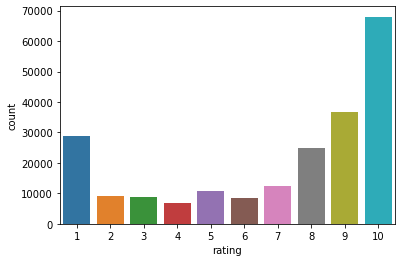

In [304]:
sns.countplot(df['rating'])

In [305]:
# data is skewed, imalanced towards positive ratings

In [306]:
df.rating.value_counts(normalize=True)

10    0.316210
9     0.170685
1     0.134463
8     0.116459
7     0.058341
5     0.049860
2     0.043080
3     0.040537
6     0.039347
4     0.031019
Name: rating, dtype: float64

### 'usefulCount' column

<AxesSubplot:xlabel='usefulCount', ylabel='count'>

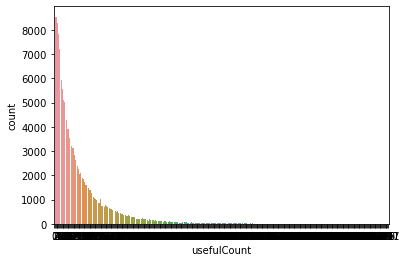

In [307]:
sns.countplot(df['usefulCount'])

<AxesSubplot:xlabel='usefulCount'>

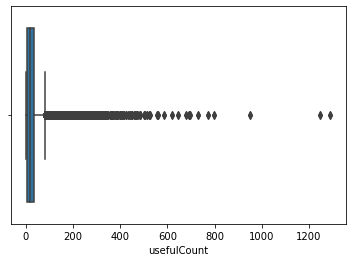

In [308]:
sns.boxplot(x=df['usefulCount'])

In [309]:
df['usefulCount'].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

In [310]:
df.loc[df['usefulCount'] == 0, 'usefulCount'].count()

8402

In [311]:
df.usefulCount.value_counts()

2      8543
3      8525
0      8402
4      8301
1      8237
       ... 
309       1
337       1
400       1
372       1
288       1
Name: usefulCount, Length: 397, dtype: int64

In [339]:
df

Unnamed: 0                  drugName                     condition  \
0          206461                 Valsartan  Left Ventricular Dysfunction   
1           95260                Guanfacine                          ADHD   
2           92703                    Lybrel                 Birth Control   
3          138000                Ortho Evra                 Birth Control   
4           35696  Buprenorphine / naloxone             Opiate Dependence   
...           ...                       ...                           ...   
53761      159999                 Tamoxifen     Breast Cancer, Prevention   
53762      140714              Escitalopram                       Anxiety   
53763      130945            Levonorgestrel                 Birth Control   
53764       47656                Tapentadol                          Pain   
53765      113712                 Arthrotec                      Sciatica   

                                                  review  rating  \
0      "It has no side effect, I take it in combinati...       9   
1      "My son is halfway through his fourth week of ...       8   
2      "I used to take another oral contraceptive, wh...       5   
3      "This is my first time using any form of birth...       8   
4      "Suboxone has completely turned my life around...       9   
...                                                  ...     ...   
53761  "I have taken Tamoxifen for 5 years. Side effe...      10   
53762  "I&#039;ve been taking Lexapro (escitaploprgra...       9   
53763  "I&#039;m married, 34 years old and I have no ...       8   
53764  "I was prescribed Nucynta for severe neck/shou...       1   
53765                                      "It works!!!"       9   

                     date  usefulCount  length  
0            May 20, 2012           27      17  
1          April 27, 2010          192     141  
2       December 14, 2009           17     134  
3        November 3, 2015           10      89  
4       November 27, 2016           37     124  
...                   ...          ...     ...  
53761  September 13, 2014           43      97  
53762     October 8, 2016           11     130  
53763   November 15, 2010            7     149  
53764   November 28, 2011           20      34  
53765  September 13, 2009           46       2  

[215063 rows x 8 columns]

### >>>>>>> Review DUP

In [330]:
uc = df.usefulCount.value_counts().reset_index().rename(columns={"index": "values_c"}) 

In [333]:
top5l = list(uc.sort_values(by="values_c",  ascending=False).reset_index(drop=True).iloc[0:5].values_c.values)

In [338]:
df.query("usefulCount in @top5l")

Unnamed: 0        drugName      condition  \
2039         62757      Citalopram     Depression   
4249        182560          Mirena  Birth Control   
6716         96616      Sertraline     Depression   
16889        52305        Adipex-P    Weight Loss   
21708       131116  Levonorgestrel  Birth Control   
33552       119152          Zoloft     Depression   
58608       139141     Phentermine    Weight Loss   
146145      119151          Zoloft     Depression   
152838       89825          Celexa     Depression   
3829         96615      Sertraline     Depression   

                                                   review  rating  \
2039    "I responded after one week. The side effects ...       8   
4249    "I have had my IUD for over a year now and I t...      10   
6716    "I remember reading people&#039;s opinions, on...      10   
16889   "I have used this pill off and on for the past...      10   
21708   "I have had my IUD for over a year now and I t...      10   
33552   "I remember reading people&#039;s opinions, on...      10   
58608   "I have used this pill off and on for the past...      10   
146145  "I&#039;ve been on Zoloft 50mg for over two ye...       9   
152838  "I responded after one week. The side effects ...       8   
3829    "I&#039;ve been on Zoloft 50mg for over two ye...       9   

                    date  usefulCount  length  
2039      March 25, 2008          771      82  
4249       April 1, 2009         1247     114  
6716       July 31, 2008         1291     187  
16889   October 19, 2008          796     142  
21708      April 1, 2009         1247     114  
33552      July 31, 2008         1291     187  
58608   October 19, 2008          796     142  
146145    August 5, 2008          949      53  
152838    March 25, 2008          771      82  
3829      August 5, 2008          949      53

In [316]:
df.loc[df.usefulCount == df.usefulCount.max(), 'review']

6716     "I remember reading people&#039;s opinions, on...
33552    "I remember reading people&#039;s opinions, on...
Name: review, dtype: object

In [313]:
df.condition.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

### General trends in the data

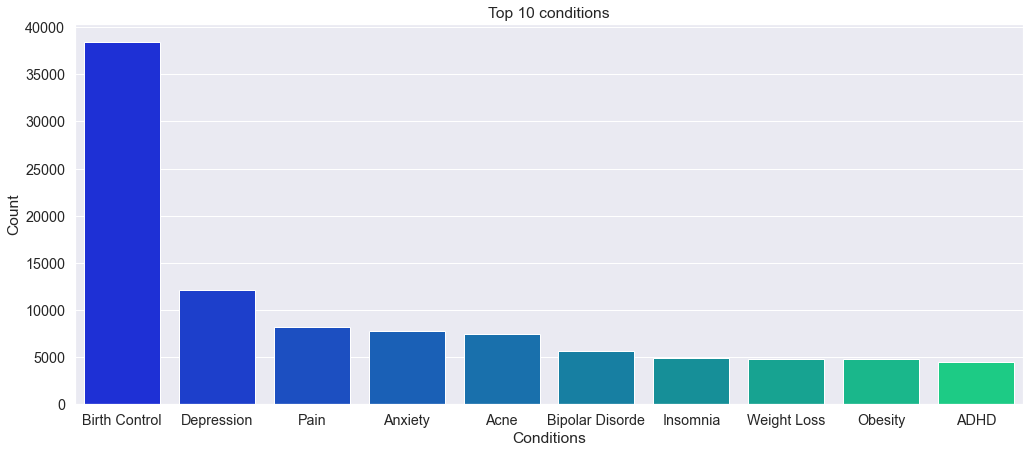

In [233]:
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [17, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

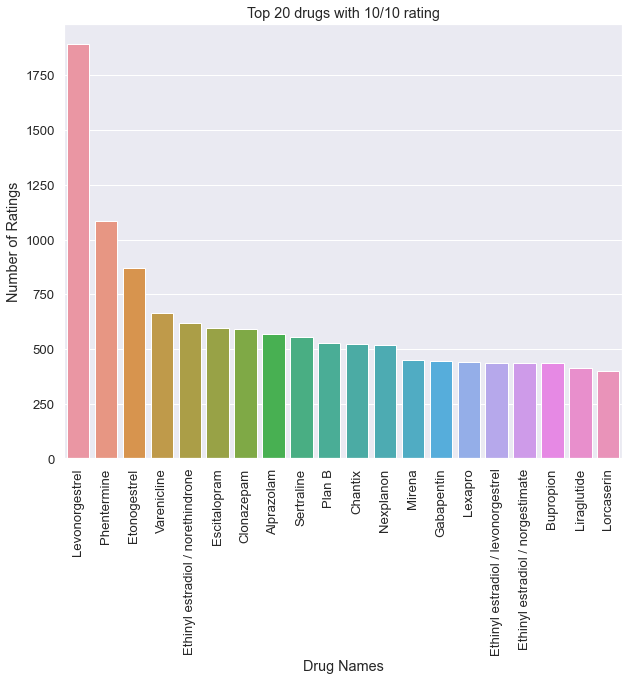

In [234]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

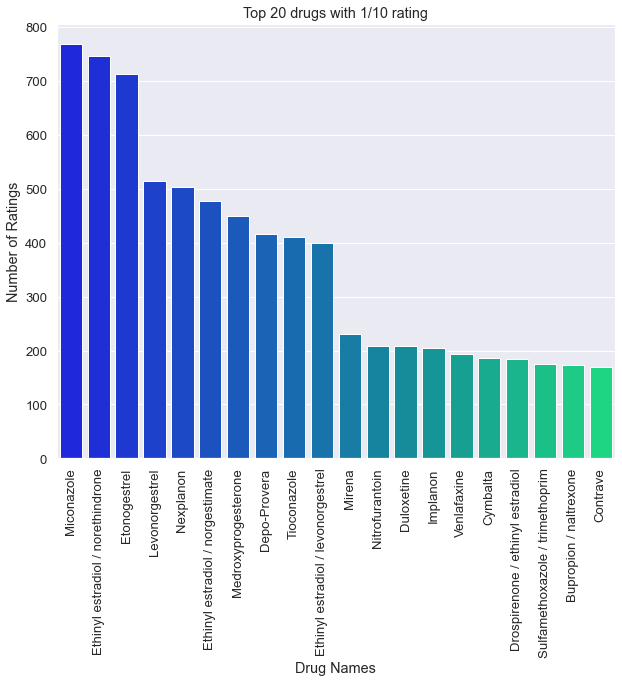

In [235]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

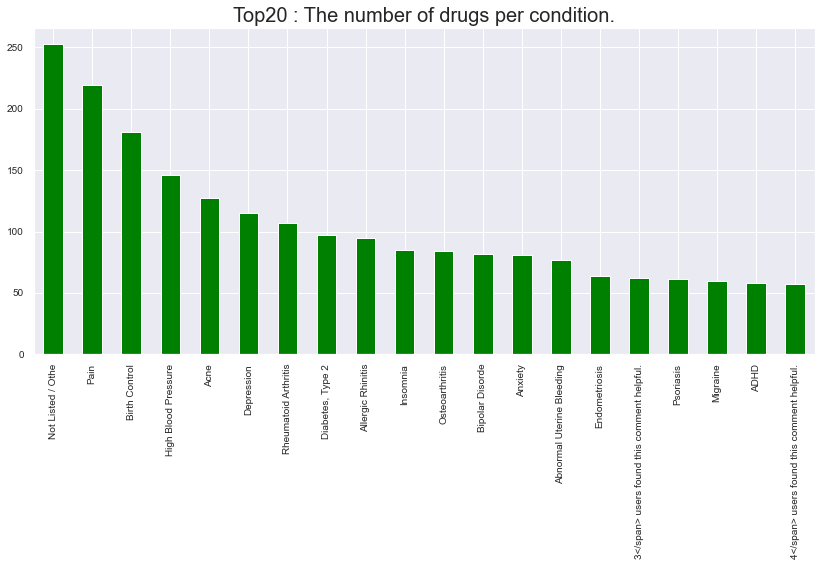

In [236]:
condition_dn = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

In [314]:
df.drugName.nunique()

3671

In [315]:
# Most useful reviews

In [ ]:
df.loc(review[max]

## Data Cleaning

### Clean 'condition' column

In [18]:
df["condition_clean"] = df.condition.apply(lambda x: "unknown" if str(x).__contains__("users found this comment helpful.") else x)

In [19]:
df.loc[df["condition_clean"] == "unknown", "condition_clean"].count() 

1171

In [20]:
df["condition_clean"].apply(lambda x: str(x).lower()).nunique()

838

In [21]:
df.condition_clean.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

In [22]:
df["condition_clean"].nunique()

837

In [23]:
#df = df.dropna()
df
# -1194 records
df.condition.fillna("unknown", axis=0, inplace=True)

### Clean reviews (inplace)

In [24]:
df.drop(["date", "condition"], axis=1, inplace=True)

In [25]:
df["review"] = df.review.str.replace("&#039;", "")
#df

In [26]:
#lower casing
df.review = df.review.str.lower()

# Removing special Characters
#df.review = df.review.str.replace(r'[^\w\d\s]',' ')

# Removing all the non ASCII characters
df.review = df.review.str.replace(r'[^\x00-\x7F]+',' ')

# Removing the leading and trailing Whitespaces
#df.review = df.review.str.replace(r'^\s+|\s+?$','')
    
# Replacing multiple Spaces with Single Space
df.review = df.review.str.replace(r'\s+',' ')
    
# Replacing Two or more dots with one
df.review = df.review.str.replace(r'\.{2,}', ' ')

In [27]:
df

drugName  \
0                     Valsartan   
1                    Guanfacine   
2                        Lybrel   
3                    Ortho Evra   
4      Buprenorphine / naloxone   
...                         ...   
53761                 Tamoxifen   
53762              Escitalopram   
53763            Levonorgestrel   
53764                Tapentadol   
53765                 Arthrotec   

                                                  review  rating  usefulCount  \
0      "it has no side effect, i take it in combinati...       9           27   
1      "my son is halfway through his fourth week of ...       8          192   
2      "i used to take another oral contraceptive, wh...       5           17   
3      "this is my first time using any form of birth...       8           10   
4      "suboxone has completely turned my life around...       9           37   
...                                                  ...     ...          ...   
53761  "i have taken tamoxifen for 5 years. side effe...      10           43   
53762  "ive been taking lexapro (escitaploprgram) sin...       9           11   
53763  "im married, 34 years old and i have no kids. ...       8            7   
53764  "i was prescribed nucynta for severe neck/shou...       1           20   
53765                                      "it works!!!"       9           46   

       length               condition_clean  
0          17  Left Ventricular Dysfunction  
1         141                          ADHD  
2         134                 Birth Control  
3          89                 Birth Control  
4         124             Opiate Dependence  
...       ...                           ...  
53761      97     Breast Cancer, Prevention  
53762     130                       Anxiety  
53763     149                 Birth Control  
53764      34                          Pain  
53765       2                      Sciatica  

[215063 rows x 6 columns]

In [28]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df_clean = df.reindex(columns=column_names)
df_clean

drugName               condition_clean  \
0                     Valsartan  Left Ventricular Dysfunction   
1                    Guanfacine                          ADHD   
2                        Lybrel                 Birth Control   
3                    Ortho Evra                 Birth Control   
4      Buprenorphine / naloxone             Opiate Dependence   
...                         ...                           ...   
53761                 Tamoxifen     Breast Cancer, Prevention   
53762              Escitalopram                       Anxiety   
53763            Levonorgestrel                 Birth Control   
53764                Tapentadol                          Pain   
53765                 Arthrotec                      Sciatica   

                                                  review  usefulCount  length  \
0      "it has no side effect, i take it in combinati...           27      17   
1      "my son is halfway through his fourth week of ...          192     141   
2      "i used to take another oral contraceptive, wh...           17     134   
3      "this is my first time using any form of birth...           10      89   
4      "suboxone has completely turned my life around...           37     124   
...                                                  ...          ...     ...   
53761  "i have taken tamoxifen for 5 years. side effe...           43      97   
53762  "ive been taking lexapro (escitaploprgram) sin...           11     130   
53763  "im married, 34 years old and i have no kids. ...            7     149   
53764  "i was prescribed nucynta for severe neck/shou...           20      34   
53765                                      "it works!!!"           46       2   

       rating  
0           9  
1           8  
2           5  
3           8  
4           9  
...       ...  
53761      10  
53762       9  
53763       8  
53764       1  
53765       9  

[215063 rows x 6 columns]

In [344]:
df.to_excel("drugs_dup.xlsx")

KeyboardInterrupt: 

In [31]:
df.loc[df_clean["length"] == max(df["length"]), "length"]
#df.loc[df["condition_clean"] == "unknown", "condition_clean"].count() 

75663    1894
Name: length, dtype: int64

In [32]:
#df.review.iat[75663]

In [33]:
df_clean_for_reg = df_clean.drop(["review"], axis=1)
df_clean_for_reg

drugName               condition_clean  usefulCount  \
0                     Valsartan  Left Ventricular Dysfunction           27   
1                    Guanfacine                          ADHD          192   
2                        Lybrel                 Birth Control           17   
3                    Ortho Evra                 Birth Control           10   
4      Buprenorphine / naloxone             Opiate Dependence           37   
...                         ...                           ...          ...   
53761                 Tamoxifen     Breast Cancer, Prevention           43   
53762              Escitalopram                       Anxiety           11   
53763            Levonorgestrel                 Birth Control            7   
53764                Tapentadol                          Pain           20   
53765                 Arthrotec                      Sciatica           46   

       length  rating  
0          17       9  
1         141       8  
2         134       5  
3          89       8  
4         124       9  
...       ...     ...  
53761      97      10  
53762     130       9  
53763     149       8  
53764      34       1  
53765       2       9  

[215063 rows x 5 columns]

In [34]:
df_clean_for_reg.to_csv("drugs_df_for_lin_reg.csv")

### Feature engineering: 'rating'

In [35]:
df['rating'] = df.rating.apply(lambda x: 0 if x <= 6 else 1)
df

drugName  \
0                     Valsartan   
1                    Guanfacine   
2                        Lybrel   
3                    Ortho Evra   
4      Buprenorphine / naloxone   
...                         ...   
53761                 Tamoxifen   
53762              Escitalopram   
53763            Levonorgestrel   
53764                Tapentadol   
53765                 Arthrotec   

                                                  review  rating  usefulCount  \
0      "it has no side effect, i take it in combinati...       1           27   
1      "my son is halfway through his fourth week of ...       1          192   
2      "i used to take another oral contraceptive, wh...       0           17   
3      "this is my first time using any form of birth...       1           10   
4      "suboxone has completely turned my life around...       1           37   
...                                                  ...     ...          ...   
53761  "i have taken tamoxifen for 5 years. side effe...       1           43   
53762  "ive been taking lexapro (escitaploprgram) sin...       1           11   
53763  "im married, 34 years old and i have no kids. ...       1            7   
53764  "i was prescribed nucynta for severe neck/shou...       0           20   
53765                                      "it works!!!"       1           46   

       length               condition_clean  
0          17  Left Ventricular Dysfunction  
1         141                          ADHD  
2         134                 Birth Control  
3          89                 Birth Control  
4         124             Opiate Dependence  
...       ...                           ...  
53761      97     Breast Cancer, Prevention  
53762     130                       Anxiety  
53763     149                 Birth Control  
53764      34                          Pain  
53765       2                      Sciatica  

[215063 rows x 6 columns]

In [36]:
df['rating'].value_counts()

1    142306
0     72757
Name: rating, dtype: int64

In [37]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df = df.reindex(columns=column_names)
df

drugName               condition_clean  \
0                     Valsartan  Left Ventricular Dysfunction   
1                    Guanfacine                          ADHD   
2                        Lybrel                 Birth Control   
3                    Ortho Evra                 Birth Control   
4      Buprenorphine / naloxone             Opiate Dependence   
...                         ...                           ...   
53761                 Tamoxifen     Breast Cancer, Prevention   
53762              Escitalopram                       Anxiety   
53763            Levonorgestrel                 Birth Control   
53764                Tapentadol                          Pain   
53765                 Arthrotec                      Sciatica   

                                                  review  usefulCount  length  \
0      "it has no side effect, i take it in combinati...           27      17   
1      "my son is halfway through his fourth week of ...          192     141   
2      "i used to take another oral contraceptive, wh...           17     134   
3      "this is my first time using any form of birth...           10      89   
4      "suboxone has completely turned my life around...           37     124   
...                                                  ...          ...     ...   
53761  "i have taken tamoxifen for 5 years. side effe...           43      97   
53762  "ive been taking lexapro (escitaploprgram) sin...           11     130   
53763  "im married, 34 years old and i have no kids. ...            7     149   
53764  "i was prescribed nucynta for severe neck/shou...           20      34   
53765                                      "it works!!!"           46       2   

       rating  
0           1  
1           1  
2           0  
3           1  
4           1  
...       ...  
53761       1  
53762       1  
53763       1  
53764       0  
53765       1  

[215063 rows x 6 columns]

## Creating the Corpus

In [38]:
reviews = ['']
corpus=[]
for review in df['review']:
    reviews.append(review)
    corpus.append(nltk.sent_tokenize(review))
corpus

[['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"'],
 ['"my son is halfway through his fourth week of intuniv.',
  'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
  'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
  'i called his doctor on monday morning and she said to stick it out a few days.',
  'see how he did at school, and with getting up in the morning.',
  'the last two days have been problem free.',
  'he is much more agreeable than ever.',
  'he is less emotional (a good thing), less cranky.',
  'he is remembering all the things he should.',
  'overall his behavior is better.',
  'we have tried many different medications and so far this is the most effective."'],
 ['"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 

In [39]:
len(corpus)

215063

In [40]:
corpus=[sent for sublist in corpus for sent in sublist]
corpus

['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"',
 '"my son is halfway through his fourth week of intuniv.',
 'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
 'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
 'i called his doctor on monday morning and she said to stick it out a few days.',
 'see how he did at school, and with getting up in the morning.',
 'the last two days have been problem free.',
 'he is much more agreeable than ever.',
 'he is less emotional (a good thing), less cranky.',
 'he is remembering all the things he should.',
 'overall his behavior is better.',
 'we have tried many different medications and so far this is the most effective."',
 '"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other 

In [41]:
len(corpus)

1253550

### Cleaning corpus

In [42]:
for i in range(len(corpus)):
    corpus[i] = re.sub(r'\d+','', corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r"\s*'\s*\w*"," ", corpus[i])
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ', corpus[i]) # Replace one or more whitespaces by  ' '    
    corpus[i] = re.sub(r'^\s+|\s+?$','', corpus[i])
corpus

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [43]:
corpus_pre_tok = corpus.copy()
corpus_pre_tok

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [44]:
# Tokenizing the corpus

In [45]:
wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

In [46]:
len(list(wordfreq.keys()))

49773

In [47]:
wordfreq

{'it': 384381,
 'has': 64543,
 'no': 80330,
 'side': 71323,
 'effect': 14623,
 'i': 998185,
 'take': 58449,
 'in': 168630,
 'combination': 2158,
 'of': 228762,
 'bystolic': 329,
 'mg': 60764,
 'and': 575215,
 'fish': 199,
 'oil': 888,
 'my': 389314,
 'son': 3069,
 'is': 150286,
 'halfway': 247,
 'through': 12769,
 'his': 4209,
 'fourth': 831,
 'week': 38269,
 'intuniv': 259,
 'we': 10003,
 'became': 5849,
 'concerned': 1258,
 'when': 48801,
 'he': 18186,
 'began': 6811,
 'this': 180956,
 'last': 21329,
 'started': 56527,
 'taking': 68293,
 'the': 542846,
 'highest': 472,
 'dose': 20990,
 'will': 35799,
 'be': 53988,
 'on': 182454,
 'for': 269085,
 'two': 28695,
 'days': 54259,
 'could': 19811,
 'hardly': 1808,
 'get': 55121,
 'out': 51296,
 'bed': 8199,
 'was': 235640,
 'very': 52954,
 'cranky': 233,
 'slept': 2383,
 'nearly': 3165,
 'hours': 21618,
 'a': 385295,
 'drive': 9491,
 'home': 4281,
 'from': 51060,
 'school': 4179,
 'vacation': 364,
 'unusual': 568,
 'him': 3967,
 'called': 

### Reducing the corpus

#### Stopwords

In [48]:
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english')) 
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [49]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

In [50]:
stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])

In [51]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]
corpus

[(71323, 'side'),
 (14623, 'effect'),
 (58449, 'take'),
 (2158, 'combination'),
 (329, 'bystolic'),
 (199, 'fish'),
 (888, 'oil'),
 (3069, 'son'),
 (247, 'halfway'),
 (831, 'fourth'),
 (38269, 'week'),
 (259, 'intuniv'),
 (5849, 'became'),
 (1258, 'concerned'),
 (6811, 'began'),
 (21329, 'last'),
 (56527, 'started'),
 (68293, 'taking'),
 (472, 'highest'),
 (20990, 'dose'),
 (28695, 'two'),
 (54259, 'days'),
 (19811, 'could'),
 (1808, 'hardly'),
 (55121, 'get'),
 (8199, 'bed'),
 (233, 'cranky'),
 (2383, 'slept'),
 (3165, 'nearly'),
 (21618, 'hours'),
 (9491, 'drive'),
 (4281, 'home'),
 (4179, 'school'),
 (364, 'vacation'),
 (568, 'unusual'),
 (3139, 'called'),
 (36711, 'doctor'),
 (1036, 'monday'),
 (13897, 'morning'),
 (10614, 'said'),
 (2390, 'stick'),
 (13471, 'see'),
 (19458, 'getting'),
 (9012, 'problem'),
 (6406, 'free'),
 (31214, 'much'),
 (12, 'agreeable'),
 (17131, 'ever'),
 (11072, 'less'),
 (3979, 'emotional'),
 (26541, 'good'),
 (13417, 'thing'),
 (537, 'remembering'),
 (103

In [52]:
corpus.sort(reverse = True)

# Here we keep only the 20 most frequent words but it can be changed to another bigger value
corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

[('side', 71323),
 ('taking', 68293),
 ('years', 62580),
 ('pain', 60591),
 ('effects', 60335),
 ('first', 59993),
 ('take', 58449),
 ('months', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('days', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('weeks', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('medication', 36951),
 ('weight', 36742),
 ('doctor', 36711),
 ('got', 36189),
 ('month', 35417),
 ('life', 33897),
 ('since', 33813)]

In [53]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 71323),
 ('taking', 68293),
 ('year', 62580),
 ('pain', 60591),
 ('effect', 60335),
 ('first', 59993),
 ('take', 58449),
 ('month', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('day', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('week', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('medication', 36951),
 ('weight', 36742),
 ('doctor', 36711),
 ('got', 36189),
 ('month', 35417),
 ('life', 33897),
 ('since', 33813)]

#### LIST 1 [FULL]

In [54]:
cols = {word[0]: [] for word in corpus_freq}
reviews = pd.DataFrame(cols)

reviews.columns

Index(['side', 'taking', 'year', 'pain', 'effect', 'first', 'take', 'month',
       'started', 'like', 'get', 'day', 'time', 'feel', 'would', 'back',
       'pill', 'one', 'week', 'took', 'also', 'period', 'medication', 'weight',
       'doctor', 'got', 'life', 'since'],
      dtype='object')

In [55]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Cleanup the tokenp
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [56]:
my_list = list(map(review_inpector, df['review'], 
                    [stop_words]*df.shape[0], [list(cols.keys())]*df.shape[0] ) )

my_list[:2]

[{'side': 1,
  'taking': 0,
  'year': 0,
  'pain': 0,
  'effect': 1,
  'first': 0,
  'take': 1,
  'month': 0,
  'started': 0,
  'like': 0,
  'get': 0,
  'day': 0,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'pill': 0,
  'one': 0,
  'week': 0,
  'took': 0,
  'also': 0,
  'period': 0,
  'medication': 0,
  'weight': 0,
  'doctor': 0,
  'got': 0,
  'life': 0,
  'since': 0},
 {'side': 0,
  'taking': 1,
  'year': 0,
  'pain': 0,
  'effect': 0,
  'first': 0,
  'take': 0,
  'month': 0,
  'started': 1,
  'like': 0,
  'get': 1,
  'day': 3,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'pill': 0,
  'one': 0,
  'week': 2,
  'took': 0,
  'also': 0,
  'period': 0,
  'medication': 1,
  'weight': 0,
  'doctor': 1,
  'got': 0,
  'life': 0,
  'since': 0}]

In [57]:
reviews = pd.DataFrame(my_list)

In [58]:
reviews

side  taking  year  pain  effect  first  take  month  started  like  \
0          1       0     0     0       1      0     1      0        0     0   
1          0       1     0     0       0      0     0      0        1     0   
2          3       1     0     0       2      1     1      0        1     0   
3          0       0     0     0       0      3     0      1        0     0   
4          0       0     1     0       0      0     0      0        1     0   
...      ...     ...   ...   ...     ...    ...   ...    ...      ...   ...   
215058     1       1     1     0       1      0     0      1        0     0   
215059     0       1     0     0       2      2     1      1        0     4   
215060     0       2     2     0       0      1     1      1        1     0   
215061     0       1     0     2       0      0     0      0        0     0   
215062     0       0     0     0       0      0     0      0        0     0   

        ...  week  took  also  period  medication  weight  doctor  got  life  \
0       ...     0     0     0       0           0       0       0    0     0   
1       ...     2     0     0       0           1       0       1    0     0   
2       ...     4     0     0       5           0       0       0    1     0   
3       ...     0     0     1       3           0       0       0    0     0   
4       ...     0     0     0       0           0       0       0    1     2   
...     ...   ...   ...   ...     ...         ...     ...     ...  ...   ...   
215058  ...     1     0     0       0           0       0       0    1     0   
215059  ...     2     1     0       0           0       0       0    0     1   
215060  ...     1     0     0       1           0       0       0    1     0   
215061  ...     0     0     0       0           0       0       0    0     0   
215062  ...     0     0     0       0           0       0       0    0     0   

        since  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
215058      0  
215059      1  
215060      0  
215061      0  
215062      0  

[215063 rows x 28 columns]

In [59]:
reviews['rating'] = df['rating'].reset_index(drop=True)
reviews

side  taking  year  pain  effect  first  take  month  started  like  \
0          1       0     0     0       1      0     1      0        0     0   
1          0       1     0     0       0      0     0      0        1     0   
2          3       1     0     0       2      1     1      0        1     0   
3          0       0     0     0       0      3     0      1        0     0   
4          0       0     1     0       0      0     0      0        1     0   
...      ...     ...   ...   ...     ...    ...   ...    ...      ...   ...   
215058     1       1     1     0       1      0     0      1        0     0   
215059     0       1     0     0       2      2     1      1        0     4   
215060     0       2     2     0       0      1     1      1        1     0   
215061     0       1     0     2       0      0     0      0        0     0   
215062     0       0     0     0       0      0     0      0        0     0   

        ...  took  also  period  medication  weight  doctor  got  life  since  \
0       ...     0     0       0           0       0       0    0     0      0   
1       ...     0     0       0           1       0       1    0     0      0   
2       ...     0     0       5           0       0       0    1     0      0   
3       ...     0     1       3           0       0       0    0     0      0   
4       ...     0     0       0           0       0       0    1     2      0   
...     ...   ...   ...     ...         ...     ...     ...  ...   ...    ...   
215058  ...     0     0       0           0       0       0    1     0      0   
215059  ...     1     0       0           0       0       0    0     1      1   
215060  ...     0     0       1           0       0       0    1     0      0   
215061  ...     0     0       0           0       0       0    0     0      0   
215062  ...     0     0       0           0       0       0    0     0      0   

        rating  
0            1  
1            1  
2            0  
3            1  
4            1  
...        ...  
215058       1  
215059       1  
215060       1  
215061       0  
215062       1  

[215063 rows x 29 columns]

#### LIST 3: stopwords incl. negation

In [202]:
stop_words = set(nltk.corpus.stopwords.words('english'))
exclude_words = set(("aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"))
new_stop_words = stop_words.difference(exclude_words)

In [210]:
new_stop_words = list(new_stop_words)

In [214]:
new_stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])

In [215]:
for i in range(len(new_stop_words)):
    new_stop_words[i] = re.sub(r"\s*'\s*\w*","",new_stop_words[i])
new_stop_words

['here',
 'doesn',
 'what',
 'a',
 'down',
 'if',
 'why',
 'them',
 'the',
 'both',
 'but',
 'at',
 'there',
 're',
 'has',
 'did',
 'that',
 'should',
 'by',
 'as',
 'while',
 'was',
 'himself',
 'of',
 'you',
 'below',
 'wouldn',
 'needn',
 't',
 'shouldn',
 'i',
 'yourself',
 'more',
 'through',
 'won',
 'he',
 'who',
 'wasn',
 'because',
 'and',
 'each',
 'an',
 'other',
 'up',
 'or',
 'off',
 'mightn',
 'after',
 'shan',
 'your',
 'once',
 'to',
 'ma',
 'don',
 'such',
 'ain',
 'do',
 'before',
 'themselves',
 'd',
 'hadn',
 'she',
 'll',
 'aren',
 'couldn',
 'all',
 'very',
 'y',
 'hasn',
 'mustn',
 'weren',
 'on',
 'into',
 'him',
 'she',
 'theirs',
 'these',
 'is',
 'under',
 'my',
 'does',
 'its',
 'his',
 'those',
 'yourselves',
 'from',
 'this',
 've',
 'few',
 'too',
 'it',
 'their',
 'you',
 'you',
 'am',
 'above',
 'myself',
 'now',
 'you',
 'how',
 'ours',
 'her',
 'we',
 'you',
 'about',
 'itself',
 'than',
 'haven',
 'when',
 'will',
 'ourselves',
 'm',
 'in',
 'should

In [216]:
corpus4 = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in new_stop_words]
corpus4

[(80330, 'no'),
 (71323, 'side'),
 (14623, 'effect'),
 (58449, 'take'),
 (2158, 'combination'),
 (329, 'bystolic'),
 (199, 'fish'),
 (888, 'oil'),
 (3069, 'son'),
 (247, 'halfway'),
 (831, 'fourth'),
 (38269, 'week'),
 (259, 'intuniv'),
 (5849, 'became'),
 (1258, 'concerned'),
 (6811, 'began'),
 (21329, 'last'),
 (56527, 'started'),
 (68293, 'taking'),
 (472, 'highest'),
 (20990, 'dose'),
 (28695, 'two'),
 (54259, 'days'),
 (19811, 'could'),
 (1808, 'hardly'),
 (55121, 'get'),
 (8199, 'bed'),
 (233, 'cranky'),
 (2383, 'slept'),
 (3165, 'nearly'),
 (21618, 'hours'),
 (9491, 'drive'),
 (4281, 'home'),
 (4179, 'school'),
 (364, 'vacation'),
 (568, 'unusual'),
 (3139, 'called'),
 (36711, 'doctor'),
 (1036, 'monday'),
 (13897, 'morning'),
 (10614, 'said'),
 (2390, 'stick'),
 (13471, 'see'),
 (19458, 'getting'),
 (9012, 'problem'),
 (6406, 'free'),
 (31214, 'much'),
 (12, 'agreeable'),
 (17131, 'ever'),
 (11072, 'less'),
 (3979, 'emotional'),
 (26541, 'good'),
 (13417, 'thing'),
 (537, 'reme

In [217]:
corpus4.sort(reverse = True)
corpus_freq4 = [(word[1],word[0]) for word in corpus4[:31]] 
corpus_freq4 = corpus_freq4[1:]
corpus_freq4

[('no', 80330),
 ('day', 77328),
 ('side', 71323),
 ('taking', 68293),
 ('years', 62580),
 ('pain', 60591),
 ('effects', 60335),
 ('first', 59993),
 ('take', 58449),
 ('months', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('days', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('weeks', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('medication', 36951),
 ('weight', 36742),
 ('doctor', 36711),
 ('got', 36189),
 ('month', 35417)]

In [218]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 71323),
 ('taking', 68293),
 ('year', 62580),
 ('pain', 60591),
 ('effect', 60335),
 ('first', 59993),
 ('take', 58449),
 ('month', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('day', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('week', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('medication', 36951),
 ('weight', 36742),
 ('doctor', 36711),
 ('got', 36189),
 ('month', 35417),
 ('life', 33897),
 ('since', 33813)]

# Modeling (FULL SAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Running the RanFor Model with n-grams

In [60]:
X = reviews.drop(columns='rating')
y = reviews['rating']
X
y

0         1
1         1
2         0
3         1
4         1
         ..
215058    1
215059    1
215060    1
215061    0
215062    1
Name: rating, Length: 215063, dtype: int64

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train, columns =['rating'])
y_test  = pd.DataFrame(y_test, columns =['rating'])

In [62]:
X_train
y_train

rating
37178        0
211366       1
109449       1
37312        1
21470        0
...        ...
65615        1
77655        1
210755       1
56088        0
38408        0

[172050 rows x 1 columns]

In [63]:
y_test.value_counts()

rating
1         28424
0         14589
dtype: int64

In [81]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train['rating'])

RandomForestClassifier()

### Making predictions with RF

In [77]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

In [78]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [79]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.81
              precision    recall  f1-score   support

           0       0.94      0.80      0.87     58168
           1       0.91      0.98      0.94    113882

    accuracy                           0.92    172050
   macro avg       0.92      0.89      0.90    172050
weighted avg       0.92      0.92      0.91    172050

Results obtained for the TEST SET
The Cohen's Kappa is: 0.57
              precision    recall  f1-score   support

           0       0.82      0.60      0.69     14589
           1       0.82      0.93      0.87     28424

    accuracy                           0.82     43013
   macro avg       0.82      0.77      0.78     43013
weighted avg       0.82      0.82      0.81     43013



#### Tuning the hyper paramters with gridsearch

In [329]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100,500],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [330]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

## grid_search.fit(X_train,y_train)

In [332]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 500}

In [340]:
clf = RandomForestClassifier(max_depth=10,max_features="sqrt",n_estimators=500, min_samples_leaf =1, bootstrap = False ,random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

1.0
0.92


In [336]:
# What does that mean?

In [334]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        3.147802      0.055282         0.126684        0.006463   
1        6.091226      0.053761         0.278779        0.022972   
2       30.293137      0.221309         1.173479        0.008749   
3        3.182400      0.097813         0.133364        0.011031   
4        6.124522      0.104234         0.265126        0.025345   
..            ...           ...              ...             ...   
67      10.489155      0.177874         0.426085        0.027448   
68      48.500343      0.261987         1.885780        0.027846   
69       4.836406      0.076248         0.189510        0.003672   
70       9.523010      0.081210         0.375830        0.006953   
71      36.783296      1.308831         1.302310        0.128961   

   param_bootstrap param_max_depth param_max_features param_min_samples_leaf  \
0             True               5               sqrt                      1   
1             True               5               sqrt                      1   
2             True               5               sqrt                      1   
3             True               5               sqrt                      2   
4             True               5               sqrt                      2   
..             ...             ...                ...                    ...   
67           False              10               log2                      1   
68           False              10               log2                      1   
69           False              10               log2                      2   
70           False              10               log2                      2   
71           False              10               log2                      2   

   param_n_estimators                                             params  ...  \
0                  50  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
1                 100  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
2                 500  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
3                  50  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
4                 100  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
..                ...                                                ...  ...   
67                100  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   
68                500  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   
69                 50  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   
70                100  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   
71                500  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   

    mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0          0.661709        0.000039               55            0.661697   
1          0.661709        0.000014               55            0.661704   
2          0.661709        0.000023               55            0.661712   
3          0.661709        0.000039               55            0.661697   
4          0.661709        0.000014               55            0.661697   
..              ...             ...              ...                 ...   
67         0.668201        0.000248               15            0.672871   
68         0.668556        0.000201               13            0.672849   
69         0.667817        0.000594               18            0.672929   
70         0.667858        0.000506               17            0.672864   
71         0.667910        0.000190               16            0.672428   

    split1_train_score  split2_train_score  split3_train_score  \
0             0.661726            0.661806            0.661719   
1             0.661712            0.661726            0.661704   
2             0.661697            0.661734            0.661712   
3             0.661726            0.661806            0.661712   
4         

In [335]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(random_state=42, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
print(np.mean(cross_val_scores))

0.8039174658529497


#### Running the Naive Bayes model

In [309]:
#y_train
#X_train

In [308]:
#nb = CategoricalNB()
#nb.fit(X_train, y_train['rating'])

(Not) Making predictions with NB

In [310]:
#y_train_pred_nb = nb.predict(X_train)
#y_test_pred_nb  = nb.predict(X_test)

Model performance

In [201]:
#model_performance_class(y_train, y_train_pred_nb, y_test, y_test_pred_nb)

### SVC instead of NB

In [311]:
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=42, tol=1e-2, max_iter=5000)

In [312]:
svm.fit(X_train, y_train)

LinearSVC(max_iter=5000, random_state=0, tol=0.01)

In [313]:
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm  = svm.predict(X_test)

In [314]:
model_performance_class(y_train, y_train_pred_svm, y_test, y_test_pred_svm)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.03
              precision    recall  f1-score   support

           0       0.51      0.05      0.09     58205
           1       0.67      0.98      0.79    113845

    accuracy                           0.66    172050
   macro avg       0.59      0.51      0.44    172050
weighted avg       0.61      0.66      0.55    172050

Results obtained for the TEST SET
The Cohen's Kappa is: 0.03
              precision    recall  f1-score   support

           0       0.50      0.05      0.08     14552
           1       0.67      0.98      0.79     28461

    accuracy                           0.66     43013
   macro avg       0.58      0.51      0.44     43013
weighted avg       0.61      0.66      0.55     43013



In [ ]:
# terrible

## TF-IDF (Term-Frequency Inverse Document-Frequency)

### Dataset prep: re-cleaning reviews

In [84]:
# Using Rafa's nice function from now on

def clean_review(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    x = x.replace(' br ',' ')

    return x

In [85]:
reviews_cleaned = df.copy()

In [86]:
reviews_cleaned = reviews_cleaned[['review','rating']]

In [87]:
reviews_cleaned.head()

review  rating
0  "it has no side effect, i take it in combinati...       1
1  "my son is halfway through his fourth week of ...       1
2  "i used to take another oral contraceptive, wh...       0
3  "this is my first time using any form of birth...       1
4  "suboxone has completely turned my life around...       1

In [88]:
reviews_cleaned['review'] = reviews_cleaned['review'].apply(lambda x: clean_review(x)) 

In [89]:
reviews_cleaned.head()

review  rating
0  it has no side effect i take it in combination...       1
1  my son is halfway through his fourth week of i...       1
2  i used to take another oral contraceptive whic...       0
3  this is my first time using any form of birth ...       1
4  suboxone has completely turned my life around ...       1

### >>> Running the TF-IDF model 

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words )

In [91]:
X_TF = tidf.fit_transform(reviews_cleaned['review'])
y_TF = reviews_cleaned['rating']

In [92]:
tidf.get_feature_names()

['aa',
 'abdomen',
 'abdominal',
 'abdominal cramping',
 'abdominal cramps',
 'abdominal pain',
 'abdominal pains',
 'abilify',
 'abilities',
 'ability',
 'ability focus',
 'ablation',
 'able',
 'able breathe',
 'able concentrate',
 'able continue',
 'able control',
 'able cope',
 'able deal',
 'able drink',
 'able drive',
 'able eat',
 'able enjoy',
 'able fall',
 'able feel',
 'able find',
 'able focus',
 'able function',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able keep',
 'able leave',
 'able live',
 'able lose',
 'able maintain',
 'able make',
 'able manage',
 'able move',
 'able quit',
 'able sex',
 'able sleep',
 'able stay',
 'able stop',
 'able take',
 'able things',
 'able think',
 'able tolerate',
 'able use',
 'able walk',
 'able wear',
 'able work',
 'abnormal',
 'abnormal bleeding',
 'abnormally',
 'abortion',
 'abreva',
 'abruptly',
 'abscess',
 'absence',
 'absent',
 'absolute',
 'absolute worst',
 'absolutely',
 'absolutely amazing',
 'absolutely awful

In [93]:
len(tidf.get_feature_names())

20000

In [94]:
X_TF[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Train test split

In [248]:
X_TF_train, X_TF_test, y_TF_train, y_TF_test = train_test_split(X_TF, y_TF, test_size=0.20, random_state=42)

In [249]:
type(X_TF_train)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [250]:
rf1 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_train = y_TF_train.astype('int')
y_TF_test  = y_TF_test.astype('int')

rf1.fit(X_TF_train, y_TF_train)

y_TF_train_pred_rf = rf1.predict(X_TF_train)
y_TF_test_pred_rf  = rf1.predict(X_TF_test)

#### Model performance

In [251]:
model_performance_class(y_TF_train, y_TF_train_pred_rf, y_TF_test, y_TF_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.99
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     58090
           1       0.99      1.00      1.00    113960

    accuracy                           1.00    172050
   macro avg       1.00      0.99      0.99    172050
weighted avg       1.00      1.00      1.00    172050

Results obtained for the TEST SET
The Cohen's Kappa is: 0.80
              precision    recall  f1-score   support

           0       0.95      0.79      0.87     14667
           1       0.90      0.98      0.94     28346

    accuracy                           0.92     43013
   macro avg       0.93      0.89      0.90     43013
weighted avg       0.92      0.92      0.91     43013



Error_metric     Train      Test
0     Accuracy  0.995199  0.915932
1    Precision  0.992907  0.900603
2       Recall  0.999895  0.980667

Confusion matrix for the train set
[[ 57276     12]
 [   814 113948]]


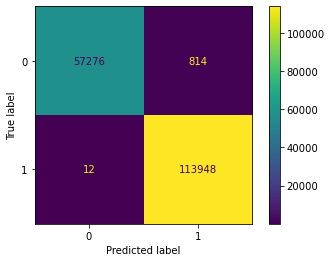



Confusion matrix for the test set
[[11599   548]
 [ 3068 27798]]


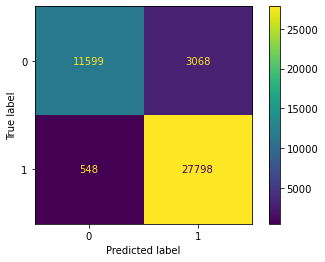

In [282]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                         precision_score(y_TF_train, y_TF_train_pred_rf),
                                         recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})

display(performance_df)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train,y_TF_train_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_train, y_TF_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test,y_TF_test_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_test,y_TF_test, values_format = 'd')
plt.show()

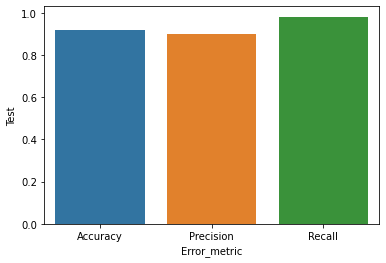

In [103]:
ax = sns.barplot(x="Error_metric", y="Test", data=performance_df)

In [510]:
# Score based on FULL sample slightly worse than DOWNsample (see below)

## LIST 1: POS tagging ins. of stopwords

### Applying tags and filtering POS

In [105]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Tokenizing

In [106]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [107]:
list_filtered = filter_review(str(corpus_pre_tok))

In [108]:
len(list_filtered)

5151492

### Reducing the list

In [109]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]

In [110]:
corpus.sort(reverse = True)

corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

[('side', 71323),
 ('taking', 68293),
 ('years', 62580),
 ('pain', 60591),
 ('effects', 60335),
 ('first', 59993),
 ('take', 58449),
 ('months', 57402),
 ('started', 56527),
 ('like', 56210),
 ('get', 55121),
 ('days', 54259),
 ('time', 51828),
 ('feel', 47466),
 ('would', 44357),
 ('back', 41727),
 ('pill', 41362),
 ('one', 40292),
 ('weeks', 39944),
 ('week', 38269),
 ('took', 37469),
 ('also', 37374),
 ('period', 37236),
 ('medication', 36951),
 ('weight', 36742),
 ('doctor', 36711),
 ('got', 36189),
 ('month', 35417),
 ('life', 33897),
 ('since', 33813)]

In [111]:
# exact same set as without POS tagging and filtering... no need to re-run models.

# DOWNSAMPLE

In [112]:
# Splitting df 

category_0 = reviews_cleaned[reviews_cleaned['rating'] == 0]
category_1 = reviews_cleaned[reviews_cleaned['rating'] == 1]
category_1
category_0

review  rating
2      i used to take another oral contraceptive whic...       0
5      nd day on  mg started to work with rock hard e...       0
6      he pulled out but he cummed a bit in me i took...       0
8      i ve had nothing but problems with the keppera...       0
12     i had crohns with a resection   years ago and ...       0
...                                                  ...     ...
53751  i took chantix a little over a month it made m...       0
53754  it didnt help me at all i craved chocolate all...       0
53758  this medicine kept me from sleeping the whole ...       0
53759  i was on microgestin for about   years over th...       0
53764  i was prescribed nucynta for severe neck shoul...       0

[72757 rows x 2 columns]

In [113]:
# Filtering df according to minority group 

category_1 = category_1.sample(len(category_0))
print(category_0.shape)
print(category_1.shape)

(72757, 2)
(72757, 2)


In [114]:
# Putting together the two splits

df_down = pd.concat([category_0, category_1], axis=0)
df_down = df_down.sample(frac=1)
df_down['rating'].value_counts()
df_down 

review  rating
55744   from about  th grade onward i experienced semi...       1
144780  i have been taking vyvanese for about   months...       1
17343          this drug was wonderful along with menopur       1
3859    i took victoza for well over a year and it imp...       1
4533    the first time that i took this medication i i...       0
...                                                   ...     ...
132778  had psoriasis on elbows and a touch on scalp w...       1
73936   i have been on the depo shot since i was aroun...       1
42601   i take   mg of zoloft and   x  mg xanax a day ...       1
152275  i started out on  mg and was okay was a little...       0
157838  only on day   but i am super happy i decided t...       1

[145514 rows x 2 columns]

### Re-running models with downsample

In [115]:
reviews2 = ['']
corpus2=[]
for review in df_down['review']:
    reviews2.append(review)
    corpus2.append(nltk.sent_tokenize(review))
corpus2

[['from about  th grade onward i experienced semiannual ovarian cysts that caused me severe pain and made me stay out of school for several days even when they did figure out what it was the doctors mainly had me stay on ibuprofen to stave off the pain finally when they realized that it wasnt working that well and that the cysts kept coming back my obgyn suggested that i start taking this medicine to regulate the hormones that were likely causing my cysts ever since i started taking this medicine several years ago i havent had a single cyst and have only had minor side effects i still pms on my quot period quot and i still get cramps on occasion but for the most part everything is fine i do think it causes bloating at times'],
 ['i have been taking vyvanese for about   months i have been taking   mg and will not up it i am   and sought help after reading some blogs about older adults taking this to help focus and have more energy i have never really taken any medication my whole life i

In [116]:
len(corpus2)

145514

In [117]:
corpus2=[sent for sublist in corpus2 for sent in sublist]
corpus2

['from about  th grade onward i experienced semiannual ovarian cysts that caused me severe pain and made me stay out of school for several days even when they did figure out what it was the doctors mainly had me stay on ibuprofen to stave off the pain finally when they realized that it wasnt working that well and that the cysts kept coming back my obgyn suggested that i start taking this medicine to regulate the hormones that were likely causing my cysts ever since i started taking this medicine several years ago i havent had a single cyst and have only had minor side effects i still pms on my quot period quot and i still get cramps on occasion but for the most part everything is fine i do think it causes bloating at times',
 'i have been taking vyvanese for about   months i have been taking   mg and will not up it i am   and sought help after reading some blogs about older adults taking this to help focus and have more energy i have never really taken any medication my whole life i ta

In [118]:
len(corpus2)

145514

### Cleaning corpus

In [119]:
for i in range(len(corpus2)):
    corpus2[i] = re.sub(r'\d+','', corpus2[i]) # Replace one or more digits by  ' '
    corpus2[i] = re.sub(r"\s*'\s*\w*"," ", corpus2[i])
    corpus2[i] = re.sub(r'\W+',' ',corpus2[i]) # Replace everything non-alpahnumeric by ' '
    corpus2[i] = re.sub(r'\s+',' ', corpus2[i]) # Replace one or more whitespaces by  ' '    
    corpus2[i] = re.sub(r'^\s+|\s+?$','', corpus2[i])
corpus2

['from about th grade onward i experienced semiannual ovarian cysts that caused me severe pain and made me stay out of school for several days even when they did figure out what it was the doctors mainly had me stay on ibuprofen to stave off the pain finally when they realized that it wasnt working that well and that the cysts kept coming back my obgyn suggested that i start taking this medicine to regulate the hormones that were likely causing my cysts ever since i started taking this medicine several years ago i havent had a single cyst and have only had minor side effects i still pms on my quot period quot and i still get cramps on occasion but for the most part everything is fine i do think it causes bloating at times',
 'i have been taking vyvanese for about months i have been taking mg and will not up it i am and sought help after reading some blogs about older adults taking this to help focus and have more energy i have never really taken any medication my whole life i take it m

In [120]:
corpus2_pre_tok = corpus2.copy()
corpus2_pre_tok

['from about th grade onward i experienced semiannual ovarian cysts that caused me severe pain and made me stay out of school for several days even when they did figure out what it was the doctors mainly had me stay on ibuprofen to stave off the pain finally when they realized that it wasnt working that well and that the cysts kept coming back my obgyn suggested that i start taking this medicine to regulate the hormones that were likely causing my cysts ever since i started taking this medicine several years ago i havent had a single cyst and have only had minor side effects i still pms on my quot period quot and i still get cramps on occasion but for the most part everything is fine i do think it causes bloating at times',
 'i have been taking vyvanese for about months i have been taking mg and will not up it i am and sought help after reading some blogs about older adults taking this to help focus and have more energy i have never really taken any medication my whole life i take it m

In [121]:
# Tokenizing the corpus

In [122]:
wordfreq2 = {}
for sentence in corpus2:
    words2 = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words2:
        if ( word not in wordfreq2.keys() ): ## first time appearnce in the sentence
            wordfreq2[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq2[word] += 1 # We increase the corresponding counter

In [123]:
len(list(wordfreq2.keys()))

43963

In [124]:
wordfreq2

{'from': 34026,
 'about': 49164,
 'th': 4936,
 'grade': 553,
 'onward': 20,
 'i': 672370,
 'experienced': 8718,
 'semiannual': 1,
 'ovarian': 613,
 'cysts': 907,
 'that': 90895,
 'caused': 5534,
 'me': 103961,
 'severe': 14054,
 'pain': 40580,
 'and': 387822,
 'made': 15791,
 'stay': 3854,
 'out': 36291,
 'of': 154854,
 'school': 2679,
 'for': 179675,
 'several': 4992,
 'days': 37238,
 'even': 17842,
 'when': 32294,
 'they': 18817,
 'did': 24976,
 'figure': 686,
 'what': 13942,
 'it': 260009,
 'was': 162107,
 'the': 368486,
 'doctors': 3774,
 'mainly': 562,
 'had': 105598,
 'on': 123763,
 'ibuprofen': 1220,
 'to': 292354,
 'stave': 10,
 'off': 23071,
 'finally': 7757,
 'realized': 1347,
 'wasnt': 6352,
 'working': 7298,
 'well': 17758,
 'kept': 2772,
 'coming': 2471,
 'back': 28393,
 'my': 264413,
 'obgyn': 575,
 'suggested': 1782,
 'start': 6591,
 'taking': 46759,
 'this': 127798,
 'medicine': 18636,
 'regulate': 786,
 'hormones': 2022,
 'were': 16091,
 'likely': 736,
 'causing': 1715

### Reducing the corpus

#### POS tagging

In [125]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

#### Generating LIST 2 [down]

In [126]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [127]:
list_filtered2 = filter_review(str(corpus2_pre_tok))

In [128]:
len(list_filtered2)

3480393

In [129]:
list_filtered2

['th',
 'grade',
 'i',
 'semiannual',
 'ovarian',
 'severe',
 'pain',
 'school',
 'several',
 'ibuprofen',
 'pain',
 'obgyn',
 'i',
 'medicine',
 'likely',
 'i',
 'medicine',
 'several',
 'i',
 'havent',
 'single',
 'cyst',
 'minor',
 'side',
 'quot',
 'period',
 'quot',
 'i',
 'occasion',
 'part',
 'everything',
 'fine',
 'i',
 'vyvanese',
 'mg',
 'help',
 'energy',
 'i',
 'medication',
 'whole',
 'life',
 'work',
 'vacation',
 'i',
 'dont',
 'blog',
 'lot',
 'other',
 'medication',
 'sociable',
 'happy',
 'able',
 'concentrate',
 'i',
 'work',
 'engineer',
 'i',
 'recommendation',
 'first',
 'thing',
 'morning',
 'food',
 'pm',
 'sleep',
 'problem',
 'i',
 'dose',
 'low',
 'drug',
 'wonderful',
 'menopur',
 'i',
 'victoza',
 'year',
 'blood',
 'sugar',
 'c',
 'high',
 'victoza',
 'i',
 'much',
 'constant',
 'diarrhea',
 'nasty',
 'egg',
 'kind',
 'extreme',
 'nausea',
 'vomiting',
 'i',
 'sick',
 'month',
 'i',
 'sick',
 'sick',
 'i',
 'few',
 'day',
 'several',
 'only',
 'thing',
 '

In [130]:
# Matching with frequencies

In [131]:
wordfreq3 = {}
for word in list_filtered2:
    if ( word not in wordfreq3.keys() ): ## first time appearnce in the sentence
        wordfreq3[word] = 1 # We initialize the corresponding counter
    else: ## if the world is already existed in the dictionalry 
        wordfreq3[word] += 1 # We increase the corresponding counter

In [132]:
len(list(wordfreq3.keys()))

31067

In [133]:
wordfreq3

{'th': 4494,
 'grade': 491,
 'i': 506877,
 'semiannual': 1,
 'ovarian': 613,
 'severe': 12829,
 'pain': 38223,
 'school': 2679,
 'several': 4970,
 'ibuprofen': 1099,
 'obgyn': 536,
 'medicine': 18442,
 'likely': 523,
 'havent': 7150,
 'single': 1623,
 'cyst': 571,
 'minor': 1567,
 'side': 46061,
 'quot': 14096,
 'period': 25935,
 'occasion': 212,
 'part': 2912,
 'everything': 6529,
 'fine': 4808,
 'vyvanese': 2,
 'mg': 29211,
 'help': 3479,
 'energy': 4455,
 'medication': 24995,
 'whole': 3756,
 'life': 20574,
 'work': 9700,
 'vacation': 243,
 'dont': 8175,
 'blog': 28,
 'lot': 10473,
 'other': 17975,
 'sociable': 50,
 'happy': 6491,
 'able': 7615,
 'concentrate': 168,
 'engineer': 12,
 'recommendation': 188,
 'first': 34694,
 'thing': 8890,
 'morning': 9068,
 'food': 3656,
 'pm': 2852,
 'sleep': 8220,
 'problem': 5833,
 'dose': 13116,
 'low': 5174,
 'drug': 15464,
 'wonderful': 1789,
 'menopur': 2,
 'victoza': 590,
 'year': 17003,
 'blood': 8598,
 'sugar': 1906,
 'c': 1781,
 'high': 6

In [134]:
corpus3 = [(wordfreq3[key],key) for key in list(wordfreq3.keys()) if key not in stop_words]
corpus3

[(4494, 'th'),
 (491, 'grade'),
 (1, 'semiannual'),
 (613, 'ovarian'),
 (12829, 'severe'),
 (38223, 'pain'),
 (2679, 'school'),
 (4970, 'several'),
 (1099, 'ibuprofen'),
 (536, 'obgyn'),
 (18442, 'medicine'),
 (523, 'likely'),
 (7150, 'havent'),
 (1623, 'single'),
 (571, 'cyst'),
 (1567, 'minor'),
 (46061, 'side'),
 (25935, 'period'),
 (212, 'occasion'),
 (2912, 'part'),
 (6529, 'everything'),
 (4808, 'fine'),
 (2, 'vyvanese'),
 (3479, 'help'),
 (4455, 'energy'),
 (24995, 'medication'),
 (3756, 'whole'),
 (20574, 'life'),
 (9700, 'work'),
 (243, 'vacation'),
 (8175, 'dont'),
 (28, 'blog'),
 (10473, 'lot'),
 (50, 'sociable'),
 (6491, 'happy'),
 (7615, 'able'),
 (168, 'concentrate'),
 (12, 'engineer'),
 (188, 'recommendation'),
 (34694, 'first'),
 (8890, 'thing'),
 (9068, 'morning'),
 (3656, 'food'),
 (2852, 'pm'),
 (8220, 'sleep'),
 (5833, 'problem'),
 (13116, 'dose'),
 (5174, 'low'),
 (15464, 'drug'),
 (1789, 'wonderful'),
 (2, 'menopur'),
 (590, 'victoza'),
 (17003, 'year'),
 (8598, '

In [142]:
corpus3.sort(reverse = True)
corpus_freq3 = [(word[1],word[0]) for word in corpus3[:31]] 
corpus_freq3 = corpus_freq3[1:]
corpus_freq3

[('side', 46061),
 ('pain', 38223),
 ('time', 35135),
 ('first', 34694),
 ('pill', 29052),
 ('week', 26356),
 ('period', 25935),
 ('medication', 24995),
 ('doctor', 24900),
 ('month', 24729),
 ('bad', 22771),
 ('weight', 22374),
 ('anxiety', 20773),
 ('life', 20574),
 ('medicine', 18442),
 ('night', 17260),
 ('control', 17115),
 ('year', 17003),
 ('good', 16831),
 ('birth', 15752),
 ('drug', 15464),
 ('great', 15307),
 ('depression', 14758),
 ('last', 14420),
 ('much', 13174),
 ('dose', 13116),
 ('severe', 12829),
 ('little', 12812),
 ('acne', 12703),
 ('mood', 11806)]

In [143]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq3 = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq3]
corpus_freq3

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 46061),
 ('pain', 38223),
 ('time', 35135),
 ('first', 34694),
 ('pill', 29052),
 ('week', 26356),
 ('period', 25935),
 ('medication', 24995),
 ('doctor', 24900),
 ('month', 24729),
 ('bad', 22771),
 ('weight', 22374),
 ('anxiety', 20773),
 ('life', 20574),
 ('medicine', 18442),
 ('night', 17260),
 ('control', 17115),
 ('year', 17003),
 ('good', 16831),
 ('birth', 15752),
 ('drug', 15464),
 ('great', 15307),
 ('depression', 14758),
 ('last', 14420),
 ('much', 13174),
 ('dose', 13116),
 ('severe', 12829),
 ('little', 12812),
 ('acne', 12703),
 ('mood', 11806)]

In [144]:
cols2 = {word[0]: [] for word in corpus_freq3}
reviews2 = pd.DataFrame(cols2)

reviews2.columns

Index(['side', 'pain', 'time', 'first', 'pill', 'week', 'period', 'medication',
       'doctor', 'month', 'bad', 'weight', 'anxiety', 'life', 'medicine',
       'night', 'control', 'year', 'good', 'birth', 'drug', 'great',
       'depression', 'last', 'much', 'dose', 'severe', 'little', 'acne',
       'mood'],
      dtype='object')

In [145]:
cols2

{'side': [],
 'pain': [],
 'time': [],
 'first': [],
 'pill': [],
 'week': [],
 'period': [],
 'medication': [],
 'doctor': [],
 'month': [],
 'bad': [],
 'weight': [],
 'anxiety': [],
 'life': [],
 'medicine': [],
 'night': [],
 'control': [],
 'year': [],
 'good': [],
 'birth': [],
 'drug': [],
 'great': [],
 'depression': [],
 'last': [],
 'much': [],
 'dose': [],
 'severe': [],
 'little': [],
 'acne': [],
 'mood': []}

In [146]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Clean up the token
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [147]:
my_list2 = list(map(review_inpector, df_down['review'], 
                    [stop_words]*df.shape[0], [list(cols2.keys())]*df.shape[0] ) )

my_list2[:2]

[{'side': 1,
  'pain': 2,
  'time': 1,
  'first': 0,
  'pill': 0,
  'week': 0,
  'period': 1,
  'medication': 0,
  'doctor': 1,
  'month': 0,
  'bad': 0,
  'weight': 0,
  'anxiety': 0,
  'life': 0,
  'medicine': 2,
  'night': 0,
  'control': 0,
  'year': 1,
  'good': 0,
  'birth': 0,
  'drug': 0,
  'great': 0,
  'depression': 0,
  'last': 0,
  'much': 0,
  'dose': 0,
  'severe': 1,
  'little': 0,
  'acne': 0,
  'mood': 0},
 {'side': 0,
  'pain': 0,
  'time': 0,
  'first': 1,
  'pill': 0,
  'week': 0,
  'period': 0,
  'medication': 2,
  'doctor': 1,
  'month': 1,
  'bad': 0,
  'weight': 0,
  'anxiety': 0,
  'life': 1,
  'medicine': 0,
  'night': 0,
  'control': 0,
  'year': 0,
  'good': 0,
  'birth': 0,
  'drug': 0,
  'great': 0,
  'depression': 0,
  'last': 0,
  'much': 0,
  'dose': 1,
  'severe': 0,
  'little': 0,
  'acne': 0,
  'mood': 0}]

In [148]:
reviews2 = pd.DataFrame(my_list2)

In [149]:
reviews2

side  pain  time  first  pill  week  period  medication  doctor  \
0          1     2     1      0     0     0       1           0       1   
1          0     0     0      1     0     0       0           2       1   
2          0     0     0      0     0     0       0           0       0   
3          0     0     0      0     0     0       0           0       0   
4          0     0     1      1     0     0       0           1       0   
...      ...   ...   ...    ...   ...   ...     ...         ...     ...   
145509     0     0     0      0     0     0       0           0       0   
145510     1     0     1      0     1     0       2           0       0   
145511     0     0     1      0     0     0       0           0       0   
145512     0     0     1      1     0     0       0           0       0   
145513     2     0     0      0     0     1       0           1       0   

        month  ...  drug  great  depression  last  much  dose  severe  little  \
0           0  ...     0      0           0     0     0     0       1       0   
1           1  ...     0      0           0     0     0     1       0       0   
2           0  ...     1      0           0     0     0     0       0       0   
3           2  ...     0      0           0     0     1     0       0       0   
4           0  ...     0      0           0     0     0     0       0       0   
...       ...  ...   ...    ...         ...   ...   ...   ...     ...     ...   
145509      1  ...     0      0           0     0     0     0       0       0   
145510      1  ...     0      0           0     0     0     0       0       0   
145511      0  ...     0      0           0     0     0     0       0       0   
145512      0  ...     0      0           0     0     0     2       0       1   
145513      0  ...     1      0           0     0     0     0       0       0   

        acne  mood  
0          0     0  
1          0     0  
2          0     0  
3          0     0  
4          0     0  
...      ...   ...  
145509     0     0  
145510     0     0  
145511     0     0  
145512     0     0  
145513     0     0  

[145514 rows x 30 columns]

In [150]:
reviews2['rating'] = df_down['rating'].reset_index(drop=True)
reviews2

side  pain  time  first  pill  week  period  medication  doctor  \
0          1     2     1      0     0     0       1           0       1   
1          0     0     0      1     0     0       0           2       1   
2          0     0     0      0     0     0       0           0       0   
3          0     0     0      0     0     0       0           0       0   
4          0     0     1      1     0     0       0           1       0   
...      ...   ...   ...    ...   ...   ...     ...         ...     ...   
145509     0     0     0      0     0     0       0           0       0   
145510     1     0     1      0     1     0       2           0       0   
145511     0     0     1      0     0     0       0           0       0   
145512     0     0     1      1     0     0       0           0       0   
145513     2     0     0      0     0     1       0           1       0   

        month  ...  great  depression  last  much  dose  severe  little  acne  \
0           0  ...      0           0     0     0     0       1       0     0   
1           1  ...      0           0     0     0     1       0       0     0   
2           0  ...      0           0     0     0     0       0       0     0   
3           2  ...      0           0     0     1     0       0       0     0   
4           0  ...      0           0     0     0     0       0       0     0   
...       ...  ...    ...         ...   ...   ...   ...     ...     ...   ...   
145509      1  ...      0           0     0     0     0       0       0     0   
145510      1  ...      0           0     0     0     0       0       0     0   
145511      0  ...      0           0     0     0     0       0       0     0   
145512      0  ...      0           0     0     0     2       0       1     0   
145513      0  ...      0           0     0     0     0       0       0     0   

        mood  rating  
0          0       1  
1          0       1  
2          0       1  
3          0       1  
4          0       0  
...      ...     ...  
145509     0       1  
145510     0       1  
145511     0       1  
145512     0       0  
145513     0       1  

[145514 rows x 31 columns]

## Modeling (DOWNSAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## >>> Running the RanFor Model with BOW

In [258]:
X2 = reviews2.drop(columns='rating')
y2 = reviews2['rating']
X2

side  pain  time  first  pill  week  period  medication  doctor  \
0          1     2     1      0     0     0       1           0       1   
1          0     0     0      1     0     0       0           2       1   
2          0     0     0      0     0     0       0           0       0   
3          0     0     0      0     0     0       0           0       0   
4          0     0     1      1     0     0       0           1       0   
...      ...   ...   ...    ...   ...   ...     ...         ...     ...   
145509     0     0     0      0     0     0       0           0       0   
145510     1     0     1      0     1     0       2           0       0   
145511     0     0     1      0     0     0       0           0       0   
145512     0     0     1      1     0     0       0           0       0   
145513     2     0     0      0     0     1       0           1       0   

        month  ...  drug  great  depression  last  much  dose  severe  little  \
0           0  ...     0      0           0     0     0     0       1       0   
1           1  ...     0      0           0     0     0     1       0       0   
2           0  ...     1      0           0     0     0     0       0       0   
3           2  ...     0      0           0     0     1     0       0       0   
4           0  ...     0      0           0     0     0     0       0       0   
...       ...  ...   ...    ...         ...   ...   ...   ...     ...     ...   
145509      1  ...     0      0           0     0     0     0       0       0   
145510      1  ...     0      0           0     0     0     0       0       0   
145511      0  ...     0      0           0     0     0     0       0       0   
145512      0  ...     0      0           0     0     0     2       0       1   
145513      0  ...     1      0           0     0     0     0       0       0   

        acne  mood  
0          0     0  
1          0     0  
2          0     0  
3          0     0  
4          0     0  
...      ...   ...  
145509     0     0  
145510     0     0  
145511     0     0  
145512     0     0  
145513     0     0  

[145514 rows x 30 columns]

In [259]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=42)

X_train2 = pd.DataFrame(X_train2, columns=X2.columns)
X_test2  = pd.DataFrame(X_test2, columns=X2.columns)

y_train2 = pd.DataFrame(y_train2, columns =['rating'])
y_test2  = pd.DataFrame(y_test2, columns =['rating'])

In [260]:
X_train2
#y_train2

side  pain  time  first  pill  week  period  medication  doctor  \
12345      0     1     0      1     0     0       0           0       0   
32810      0     0     0      0     0     1       0           0       0   
135448     0     0     0      0     0     0       0           0       0   
142692     0     0     0      0     0     2       0           0       0   
102325     0     0     0      0     0     2       0           0       0   
...      ...   ...   ...    ...   ...   ...     ...         ...     ...   
110268     1     0     0      0     1     1       1           0       0   
119879     0     0     1      0     0     1       0           0       1   
103694     0     0     0      0     0     0       0           0       0   
131932     0     0     0      0     1     0       0           0       1   
121958     0     0     0      0     0     0       0           0       0   

        month  ...  drug  great  depression  last  much  dose  severe  little  \
12345       0  ...     0      1           0     0     0     0       0       0   
32810       0  ...     0      0           0     1     0     0       0       0   
135448      0  ...     0      0           0     0     0     0       0       0   
142692      0  ...     0      1           0     1     0     0       0       0   
102325      0  ...     1      0           0     0     1     0       0       0   
...       ...  ...   ...    ...         ...   ...   ...   ...     ...     ...   
110268      3  ...     0      1           2     1     0     0       0       0   
119879      0  ...     0      0           1     0     0     0       0       0   
103694      0  ...     0      0           0     0     0     0       0       0   
131932      0  ...     1      0           0     0     0     0       0       0   
121958      0  ...     0      0           0     0     0     0       0       0   

        acne  mood  
12345      1     0  
32810      0     0  
135448     0     0  
142692     0     1  
102325     0     0  
...      ...   ...  
110268     0     0  
119879     0     1  
103694     0     0  
131932     0     0  
121958     0     0  

[116411 rows x 30 columns]

In [261]:
y_test2.value_counts()

rating
0         14570
1         14533
dtype: int64

In [263]:
rf2 = RandomForestClassifier()

rf2.fit(X_train2, y_train2['rating'])

RandomForestClassifier()

### Making predictions with RF

In [264]:
y_train_pred_rf2 = rf2.predict(X_train2)
y_test_pred_rf2  = rf2.predict(X_test2)

In [265]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [266]:
model_performance_class(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.73
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     58187
           1       0.90      0.83      0.86     58224

    accuracy                           0.87    116411
   macro avg       0.87      0.87      0.87    116411
weighted avg       0.87      0.87      0.87    116411

Results obtained for the TEST SET
The Cohen's Kappa is: 0.47
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     14570
           1       0.77      0.68      0.72     14533

    accuracy                           0.74     29103
   macro avg       0.74      0.74      0.74     29103
weighted avg       0.74      0.74      0.74     29103



In [160]:
# After balancing, overall score is lower, precision overall lower
# test + train set recall better for lower rating drugs [0] (less false positives)
# But more false negatives - good drugs [1] are predicted as bad more often

#### Tuning the hyper paramters with gridsearch

In [455]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100,500],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [456]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

## grid_search.fit(X_train2,y_train2)

In [458]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 500}

In [459]:
clf = RandomForestClassifier(max_depth=10,max_features="sqrt",n_estimators=500, min_samples_leaf =1, random_state=42)
clf.fit(X_train2, y_train2)
print(clf.score(X_train2, y_train2))
print(clf.score(X_test2, y_test2))

0.6483751535507812
0.6278046936741917


In [460]:
# What does that mean?

In [461]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.748535      0.040802         0.086254        0.001073   
1        3.325761      0.104754         0.178785        0.012075   
2       15.618697      0.193848         0.715494        0.019163   
3        1.596555      0.029282         0.075899        0.005487   
4        3.163166      0.101459         0.161896        0.016463   
..            ...           ...              ...             ...   
67       5.449727      0.104022         0.249627        0.017193   
68      26.014199      0.159995         1.158326        0.039274   
69       2.585034      0.092714         0.122807        0.007078   
70       5.112355      0.131607         0.254947        0.035667   
71      20.138168      0.726030         0.800914        0.058823   

   param_bootstrap param_max_depth param_max_features param_min_samples_leaf  \
0             True               5               sqrt                      1   
1             True               5               sqrt                      1   
2             True               5               sqrt                      1   
3             True               5               sqrt                      2   
4             True               5               sqrt                      2   
..             ...             ...                ...                    ...   
67           False              10               log2                      1   
68           False              10               log2                      1   
69           False              10               log2                      2   
70           False              10               log2                      2   
71           False              10               log2                      2   

   param_n_estimators                                             params  ...  \
0                  50  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
1                 100  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
2                 500  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
3                  50  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
4                 100  {'bootstrap': True, 'max_depth': 5, 'max_featu...  ...   
..                ...                                                ...  ...   
67                100  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   
68                500  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   
69                 50  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   
70                100  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   
71                500  {'bootstrap': False, 'max_depth': 10, 'max_fea...  ...   

    mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0          0.613799        0.004828               62            0.616302   
1          0.613207        0.004632               69            0.614810   
2          0.613482        0.004022               66            0.615271   
3          0.613524        0.004710               64            0.616216   
4          0.612992        0.004695               71            0.614831   
..              ...             ...              ...                 ...   
67         0.632990        0.004469                5            0.652178   
68         0.633162        0.003667                3            0.652178   
69         0.631298        0.003885               18            0.648548   
70         0.631727        0.003834               16            0.649064   
71         0.632243        0.003631               11            0.650803   

    split1_train_score  split2_train_score  split3_train_score  \
0             0.616607            0.616586            0.614427   
1             0.614706            0.613837            0.613654   
2             0.615351            0.614105            0.614502   
3             0.616339            0.616489            0.614384   
4         

In [462]:
clf = RandomForestClassifier(random_state=42, max_features='sqrt', 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=100)
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

0.7208683259550622


## TF_IDF DOWNSAMPLE

### >>> With uni + bigrams

In [161]:
df_down

review  rating
55744   from about  th grade onward i experienced semi...       1
144780  i have been taking vyvanese for about   months...       1
17343          this drug was wonderful along with menopur       1
3859    i took victoza for well over a year and it imp...       1
4533    the first time that i took this medication i i...       0
...                                                   ...     ...
132778  had psoriasis on elbows and a touch on scalp w...       1
73936   i have been on the depo shot since i was aroun...       1
42601   i take   mg of zoloft and   x  mg xanax a day ...       1
152275  i started out on  mg and was okay was a little...       0
157838  only on day   but i am super happy i decided t...       1

[145514 rows x 2 columns]

In [162]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [ ]:
X_TF2 = tidf.fit_transform(df_down['review'])
y_TF2 = df_down['rating']

In [ ]:
y_TF2

In [165]:
tidf.get_feature_names()

['aa',
 'abdomen',
 'abdominal',
 'abdominal cramping',
 'abdominal cramps',
 'abdominal pain',
 'abdominal pains',
 'abilify',
 'abilities',
 'ability',
 'ablation',
 'able',
 'able breathe',
 'able concentrate',
 'able continue',
 'able control',
 'able cope',
 'able drive',
 'able eat',
 'able enjoy',
 'able fall',
 'able feel',
 'able find',
 'able focus',
 'able function',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able keep',
 'able live',
 'able lose',
 'able maintain',
 'able make',
 'able move',
 'able quit',
 'able sex',
 'able sleep',
 'able stay',
 'able stop',
 'able take',
 'able think',
 'able tolerate',
 'able use',
 'able walk',
 'able wear',
 'able work',
 'abnormal',
 'abnormal bleeding',
 'abnormally',
 'abortion',
 'abreva',
 'abruptly',
 'abscess',
 'absence',
 'absolute',
 'absolute worst',
 'absolutely',
 'absolutely amazing',
 'absolutely awful',
 'absolutely hate',
 'absolutely horrible',
 'absolutely love',
 'absolutely loved',
 'absolutely mise

In [166]:
len(tidf.get_feature_names())

20000

In [167]:
X_TF2[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Train test split

In [274]:
X_TF_train2, X_TF_test2, y_TF_train2, y_TF_test2 = train_test_split(X_TF2, y_TF2, test_size=0.20, random_state=42)

In [275]:
type(X_TF_train2)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [273]:
rf3 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_train2 = y_TF_train2.astype('int')
y_TF_test2  = y_TF_test2.astype('int')

rf3.fit(X_TF_train2, y_TF_train2)

y_TF_train_pred_rf2 = rf3.predict(X_TF_train2)
y_TF_test_pred_rf2  = rf3.predict(X_TF_test2)

#### Model performance

In [276]:
model_performance_class(y_TF_train2, y_TF_train_pred_rf2, y_TF_test2, y_TF_test_pred_rf2)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58187
           1       1.00      1.00      1.00     58224

    accuracy                           1.00    116411
   macro avg       1.00      1.00      1.00    116411
weighted avg       1.00      1.00      1.00    116411

Results obtained for the TEST SET
The Cohen's Kappa is: 0.78
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     14570
           1       0.90      0.87      0.89     14533

    accuracy                           0.89     29103
   macro avg       0.89      0.89      0.89     29103
weighted avg       0.89      0.89      0.89     29103



In [513]:
# best results obtained with uni- AND bi-grams, max_depth 200

Error_metric     Train      Test
0     Accuracy  0.997724  0.887606
1    Precision  0.998933  0.902329
2       Recall  0.996513  0.868988

Confusion matrix for the train set
[[58125   203]
 [   62 58021]]


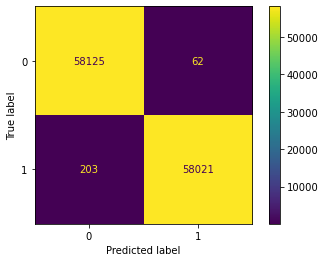



Confusion matrix for the test set
[[13203  1904]
 [ 1367 12629]]


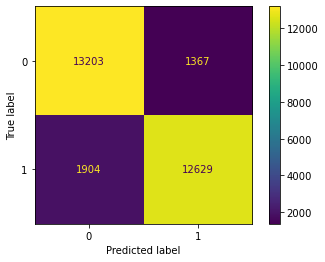

In [281]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df_best = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                                         precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})

display(performance_df_best)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train2,y_TF_train_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_train2, y_TF_train2, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test2,y_TF_test_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_test2,y_TF_test2, values_format = 'd')
plt.show()

### >>> With bigrams only

In [234]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (2,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [253]:
X_TF_down_bi = tidf.fit_transform(df_down['review'])
y_TF_down_bi = df_down['rating']

#### Train test split

In [267]:
X_TF_down_bi_train, X_TF_down_bi_test, y_TF_down_bi_train, y_TF_down_bi_test = train_test_split(X_TF_down_bi, y_TF_down_bi, test_size=0.20, random_state=42)

In [268]:
type(X_TF_down_bi_train)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [269]:
rf4 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_down_bi_train = y_TF_down_bi_train.astype('int')
y_TF_down_bi_test  = y_TF_down_bi_test.astype('int')

rf4.fit(X_TF_down_bi_train, y_TF_down_bi_train)

y_TF_down_bi_train_pred_rf = rf4.predict(X_TF_down_bi_train)
y_TF_down_bi_test_pred_rf  = rf4.predict(X_TF_down_bi_test)

#### Model performance

In [270]:
model_performance_class(y_TF_down_bi_train, y_TF_down_bi_train_pred_rf, y_TF_down_bi_test, 
                        y_TF_down_bi_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.83
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     58187
           1       0.97      0.85      0.91     58224

    accuracy                           0.91    116411
   macro avg       0.92      0.91      0.91    116411
weighted avg       0.92      0.91      0.91    116411

Results obtained for the TEST SET
The Cohen's Kappa is: 0.62
              precision    recall  f1-score   support

           0       0.77      0.89      0.83     14570
           1       0.87      0.73      0.79     14533

    accuracy                           0.81     29103
   macro avg       0.82      0.81      0.81     29103
weighted avg       0.82      0.81      0.81     29103



#### Tuning the hyper paramters with gridsearch

In [547]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [150, 200],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [548]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [551]:
grid_search.fit(X_TF_train2,y_TF_train2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [150, 200],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100, 500]},
             return_train_score=True)

In [553]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 200,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 500}

In [242]:
#pd.DataFrame(grid_search.cv_results_)

In [555]:
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

0.7148944982607791


In [180]:
metrics.RocCurveDisplay

sklearn.metrics._plot.roc_curve.RocCurveDisplay

In [183]:
metrics.RocCurveDisplay.from_estimator

<bound method RocCurveDisplay.from_estimator of <class 'sklearn.metrics._plot.roc_curve.RocCurveDisplay'>>

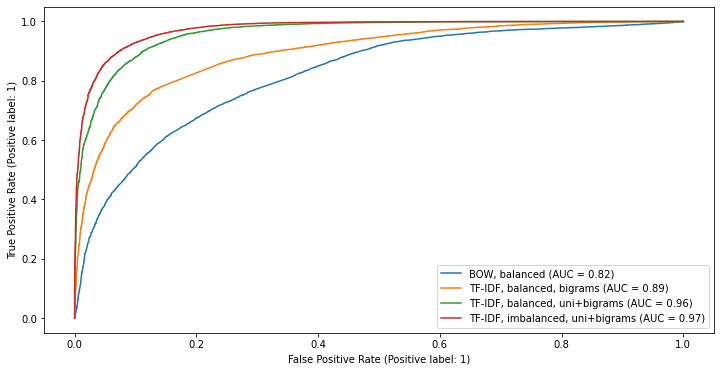

In [280]:
# 1 - BOW, down
disp = plot_roc_curve(rf2, X_test2, y_test2, name="BOW, balanced")
plt.gcf().set_size_inches(12,6)
#2 - TF-IDF down bi grams
plot_roc_curve(rf4, X_TF_down_bi_test, y_TF_down_bi_test, name="TF-IDF, balanced, bigrams", ax=disp.ax_);

#3 - TF-IDF down uni/bi grams
plot_roc_curve(rf3, X_TF_test2, y_TF_test2, name="TF-IDF, balanced, uni+bigrams", ax=disp.ax_);

#4 - TF-IDF full uni/bi grams
plot_roc_curve(rf1, X_TF_test, y_TF_test, name="TF-IDF, imbalanced, uni+bigrams", ax=disp.ax_);

In [278]:
# Plot recall (chose green option as recall for cat 1 is better)

In [285]:
performance_df1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                #         precision_score(y_TF_train, y_TF_train_pred_rf),
                                 #        recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})
performance_df_best1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                               #          precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                #         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})


In [286]:
performance_df1

Error_metric      Test
0     Accuracy  0.915932
1    Precision  0.900603
2       Recall  0.980667

In [287]:
performance_df_best1

Error_metric      Test
0     Accuracy  0.887606
1    Precision  0.902329
2       Recall  0.868988

In [131]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from nltk.corpus import stopwords
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import nltk
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay, plot_roc_curve
from sklearn.svm import SVC
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/odelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/odelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/odelia/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/odelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [132]:
df_train = pd.read_csv("data/drugsComTrain_raw.tsv", sep='\t', index_col=[0])
df_test = pd.read_csv("data/drugsComTest_raw.tsv", sep='\t', index_col=[0])

## Preliminary data exploration

In [133]:
df_train['length'] = list(map(lambda x: len(str(x).split()), df_train['review']))
df_test['length'] = list(map(lambda x: len(str(x).split()), df_test['review']))

In [134]:
# Merge train and test sets

In [135]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)

In [136]:
df

drugName                     condition  \
0                      Valsartan  Left Ventricular Dysfunction   
1                     Guanfacine                          ADHD   
2                         Lybrel                 Birth Control   
3                     Ortho Evra                 Birth Control   
4       Buprenorphine / naloxone             Opiate Dependence   
...                          ...                           ...   
215058                 Tamoxifen     Breast Cancer, Prevention   
215059              Escitalopram                       Anxiety   
215060            Levonorgestrel                 Birth Control   
215061                Tapentadol                          Pain   
215062                 Arthrotec                      Sciatica   

                                                   review  rating  \
0       "It has no side effect, I take it in combinati...     9.0   
1       "My son is halfway through his fourth week of ...     8.0   
2       "I used to take another oral contraceptive, wh...     5.0   
3       "This is my first time using any form of birth...     8.0   
4       "Suboxone has completely turned my life around...     9.0   
...                                                   ...     ...   
215058  "I have taken Tamoxifen for 5 years. Side effe...    10.0   
215059  "I&#039;ve been taking Lexapro (escitaploprgra...     9.0   
215060  "I&#039;m married, 34 years old and I have no ...     8.0   
215061  "I was prescribed Nucynta for severe neck/shou...     1.0   
215062                                      "It works!!!"     9.0   

                      date  usefulCount  length  
0             May 20, 2012           27      17  
1           April 27, 2010          192     141  
2        December 14, 2009           17     134  
3         November 3, 2015           10      89  
4        November 27, 2016           37     124  
...                    ...          ...     ...  
215058  September 13, 2014           43      97  
215059     October 8, 2016           11     130  
215060   November 15, 2010            7     149  
215061   November 28, 2011           20      34  
215062  September 13, 2009           46       2  

[215063 rows x 7 columns]

### Removal of duplicates!

In [137]:
df = df.drop_duplicates(subset=["condition" ,"review", "rating"]).reset_index(drop=True)

In [138]:
df.drugName.value_counts()

Levonorgestrel                       2533
Etonogestrel                         2245
Ethinyl estradiol / norethindrone    1945
Phentermine                          1813
Ethinyl estradiol / norgestimate     1519
                                     ... 
Motofen                                 1
Dextrostat                              1
Oxymetholone                            1
Locoid Lipocream                        1
Fluorometholone                         1
Name: drugName, Length: 3199, dtype: int64

In [139]:
df.condition.value_counts()

Birth Control                                   19524
Depression                                       7113
Pain                                             5193
Anxiety                                          5091
Acne                                             4551
                                                ...  
Somatoform Pain Disorde                             1
Esophageal Spasm                                    1
Campylobacter Gastroenteritis                       1
Peyronie's Disease                                  1
105</span> users found this comment helpful.        1
Name: condition, Length: 916, dtype: int64

In [140]:
# No duplication
df.describe()

rating    usefulCount         length
count  130285.000000  130285.000000  130285.000000
mean        6.997582      26.924059      84.258242
std         3.274199      35.135337      44.962225
min         1.000000       0.000000       1.000000
25%         5.000000       6.000000      48.000000
50%         8.000000      15.000000      84.000000
75%        10.000000      35.000000     126.000000
max        10.000000    1291.000000    1894.000000

In [141]:
df

drugName                     condition  \
0                      Valsartan  Left Ventricular Dysfunction   
1                     Guanfacine                          ADHD   
2                         Lybrel                 Birth Control   
3                     Ortho Evra                 Birth Control   
4       Buprenorphine / naloxone             Opiate Dependence   
...                          ...                           ...   
130280                 Methadone                          Pain   
130281              Clomipramine                 Panic Disorde   
130282             Levetiracetam                      Epilepsy   
130283                 Tamoxifen     Breast Cancer, Prevention   
130284              Escitalopram                       Anxiety   

                                                   review  rating  \
0       "It has no side effect, I take it in combinati...     9.0   
1       "My son is halfway through his fourth week of ...     8.0   
2       "I used to take another oral contraceptive, wh...     5.0   
3       "This is my first time using any form of birth...     8.0   
4       "Suboxone has completely turned my life around...     9.0   
...                                                   ...     ...   
130280  "Have been taking it for 6 years (120 milligra...    10.0   
130281  "I&#039;ve been on clomipramine 15 years now a...    10.0   
130282  "I now suffer from excessive tiredness and lac...     8.0   
130283  "I have taken Tamoxifen for 5 years. Side effe...    10.0   
130284  "I&#039;ve been taking Lexapro (escitaploprgra...     9.0   

                      date  usefulCount  length  
0             May 20, 2012           27      17  
1           April 27, 2010          192     141  
2        December 14, 2009           17     134  
3         November 3, 2015           10      89  
4        November 27, 2016           37     124  
...                    ...          ...     ...  
130280      August 2, 2011           16      12  
130281   February 19, 2013           28      49  
130282       July 21, 2016            5      20  
130283  September 13, 2014           43      97  
130284     October 8, 2016           11     130  

[130285 rows x 7 columns]

In [142]:
# Convert rating from float to int

df.rating = df.rating.astype(int)

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130285 entries, 0 to 130284
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   drugName     130285 non-null  object
 1   condition    129091 non-null  object
 2   review       130285 non-null  object
 3   rating       130285 non-null  int64 
 4   date         130285 non-null  object
 5   usefulCount  130285 non-null  int64 
 6   length       130285 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 7.0+ MB


In [144]:
df.isnull().any()

drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
length         False
dtype: bool

In [145]:
sum(df.condition.isnull())

1194

### 'Rating' column

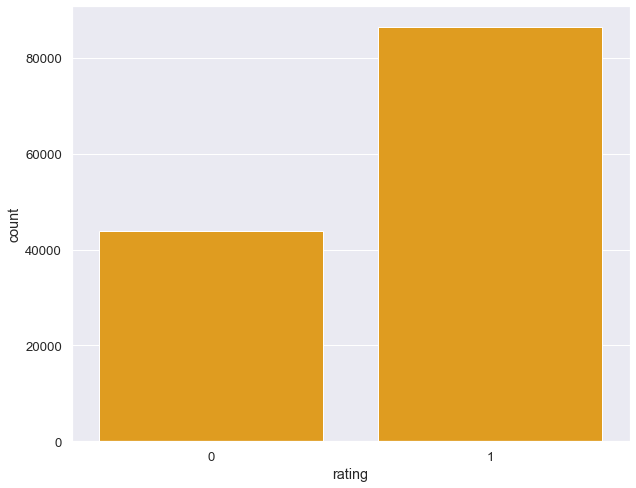

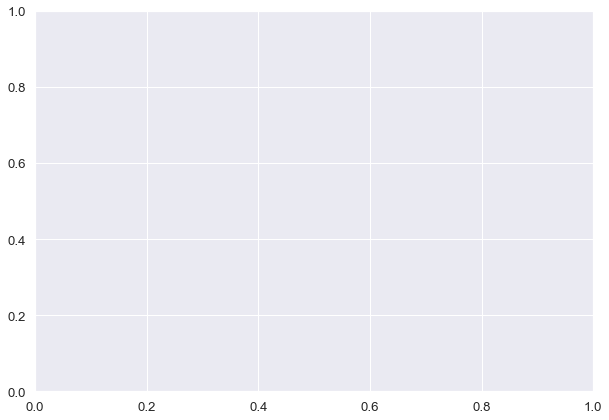

In [378]:
sns.countplot(df['rating'], color="orange")

In [147]:
# data is skewed, imalanced towards positive ratings

In [148]:
df.rating.value_counts(normalize=True)

10    0.316744
9     0.170595
1     0.135303
8     0.117182
7     0.058902
5     0.049729
2     0.042146
3     0.039567
6     0.039375
4     0.030456
Name: rating, dtype: float64

### 'usefulCount' column

<AxesSubplot:xlabel='usefulCount', ylabel='count'>

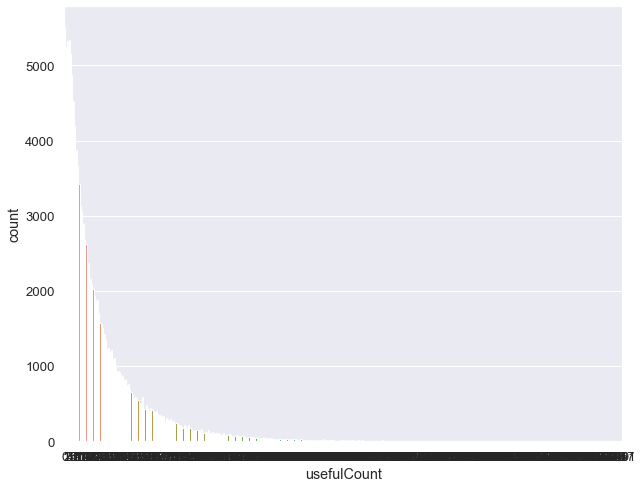

In [149]:
sns.countplot(df['usefulCount'])

<AxesSubplot:xlabel='usefulCount'>

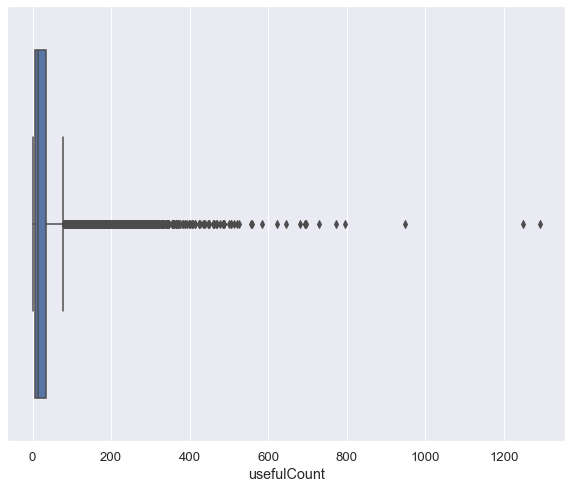

In [150]:
sns.boxplot(x=df['usefulCount'])

In [151]:
df['usefulCount'].describe()

count    130285.000000
mean         26.924059
std          35.135337
min           0.000000
25%           6.000000
50%          15.000000
75%          35.000000
max        1291.000000
Name: usefulCount, dtype: float64

In [152]:
df.loc[df['usefulCount'] == 0, 'usefulCount'].count()

5510

In [153]:
df.usefulCount.value_counts()

0      5510
3      5340
2      5332
1      5251
4      5156
       ... 
357       1
331       1
307       1
301       1
324       1
Name: usefulCount, Length: 397, dtype: int64

In [154]:
df

drugName                     condition  \
0                      Valsartan  Left Ventricular Dysfunction   
1                     Guanfacine                          ADHD   
2                         Lybrel                 Birth Control   
3                     Ortho Evra                 Birth Control   
4       Buprenorphine / naloxone             Opiate Dependence   
...                          ...                           ...   
130280                 Methadone                          Pain   
130281              Clomipramine                 Panic Disorde   
130282             Levetiracetam                      Epilepsy   
130283                 Tamoxifen     Breast Cancer, Prevention   
130284              Escitalopram                       Anxiety   

                                                   review  rating  \
0       "It has no side effect, I take it in combinati...       9   
1       "My son is halfway through his fourth week of ...       8   
2       "I used to take another oral contraceptive, wh...       5   
3       "This is my first time using any form of birth...       8   
4       "Suboxone has completely turned my life around...       9   
...                                                   ...     ...   
130280  "Have been taking it for 6 years (120 milligra...      10   
130281  "I&#039;ve been on clomipramine 15 years now a...      10   
130282  "I now suffer from excessive tiredness and lac...       8   
130283  "I have taken Tamoxifen for 5 years. Side effe...      10   
130284  "I&#039;ve been taking Lexapro (escitaploprgra...       9   

                      date  usefulCount  length  
0             May 20, 2012           27      17  
1           April 27, 2010          192     141  
2        December 14, 2009           17     134  
3         November 3, 2015           10      89  
4        November 27, 2016           37     124  
...                    ...          ...     ...  
130280      August 2, 2011           16      12  
130281   February 19, 2013           28      49  
130282       July 21, 2016            5      20  
130283  September 13, 2014           43      97  
130284     October 8, 2016           11     130  

[130285 rows x 7 columns]

In [155]:
# Positive reviews found more useful (based on tableau graph)

In [156]:
#uc = df.usefulCount.value_counts().reset_index().rename(columns={"index": "values_c"}) 

In [157]:
#top5l = list(uc.sort_values(by="values_c",  ascending=False).reset_index(drop=True).iloc[0:5].values_c.values)

In [158]:
#df.query("usefulCount in @top5l")

In [159]:
#df.loc[df.usefulCount == df.usefulCount.max(), 'review']

In [160]:
#df.condition.unique()

### General trends in the data

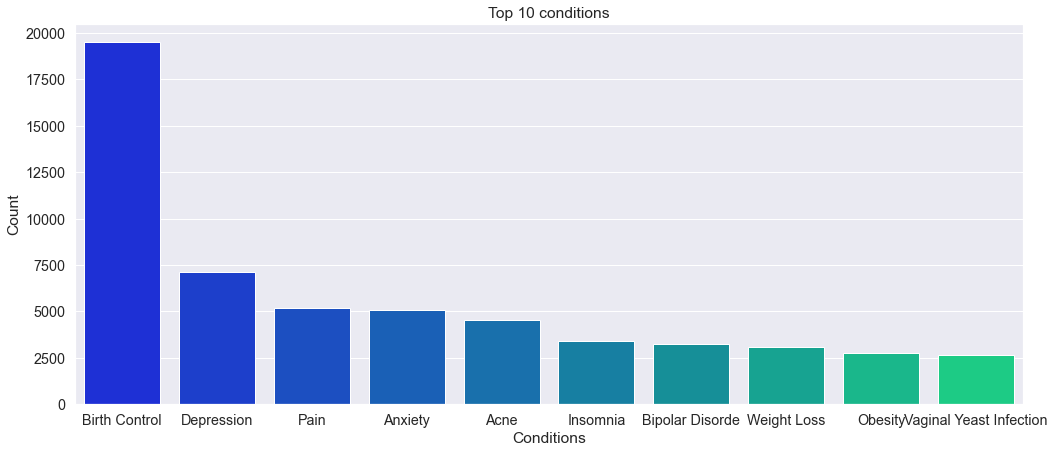

In [161]:
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [17, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

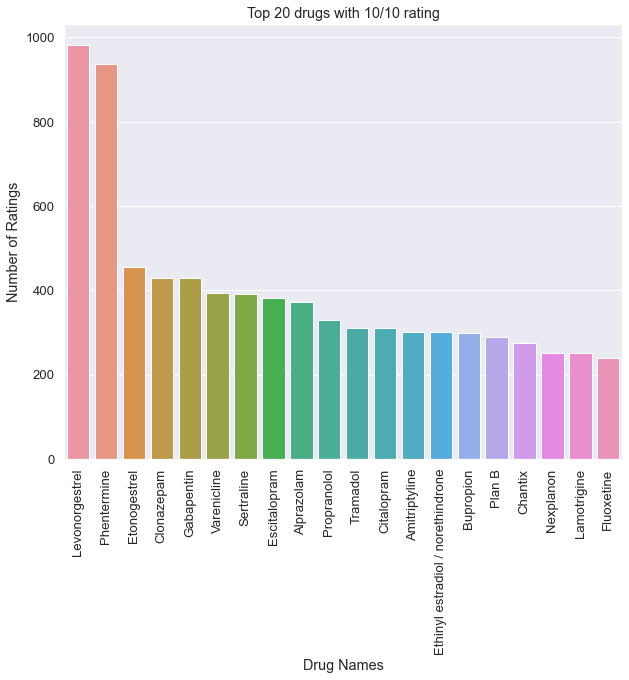

In [162]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

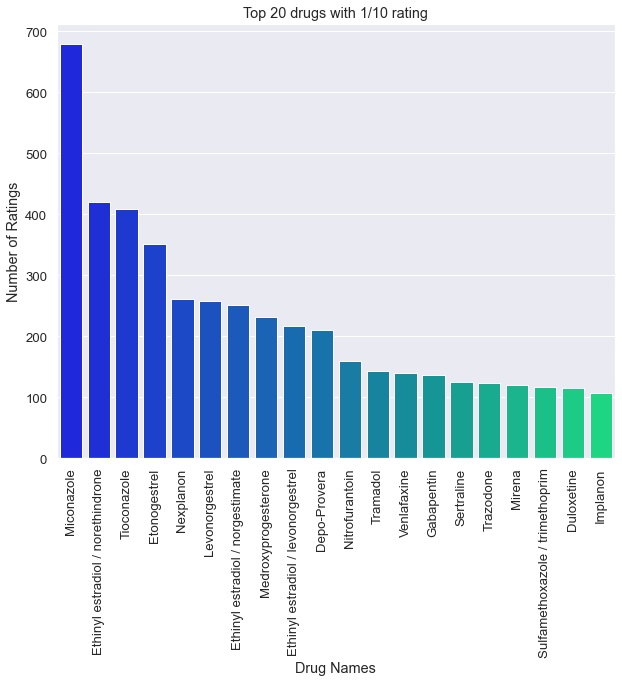

In [163]:
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

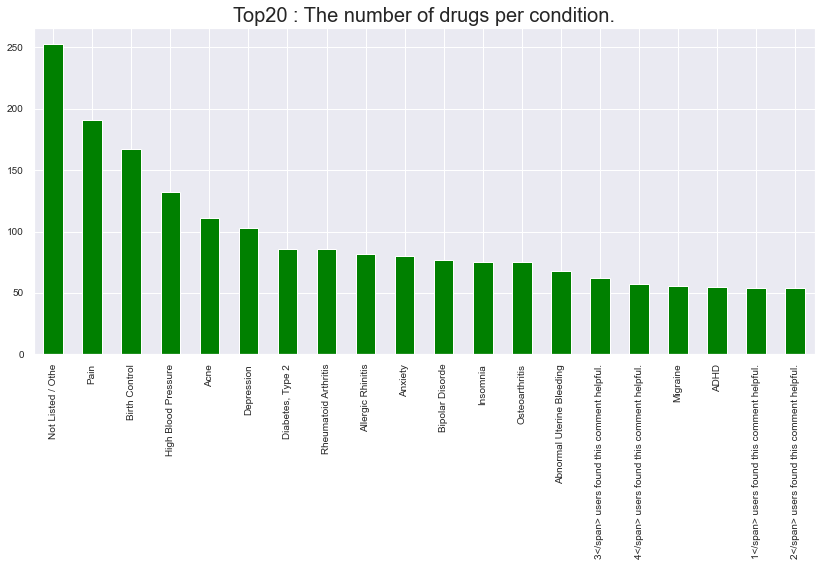

In [164]:
condition_dn = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

In [165]:
df.drugName.nunique()

3199

In [166]:
df.condition.nunique()

916

## Data Cleaning

### Clean 'condition' column

In [167]:
df["condition_clean"] = df.condition.apply(lambda x: "Unknown" if str(x).__contains__("users found this comment helpful.") else x)

In [168]:
df.loc[df["condition_clean"] == "Unknown", "condition_clean"].count() 

1171

In [169]:
df["condition_clean"].apply(lambda x: str(x).lower()).nunique()

838

In [170]:
df.condition_clean.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       nan, 'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'U

In [171]:
df["condition_clean"].nunique()

837

In [172]:
df["condition_clean"].isnull().sum()

1194

In [173]:
df["condition_clean"].fillna("Unknown", axis=0, inplace=True)
df

drugName                     condition  \
0                      Valsartan  Left Ventricular Dysfunction   
1                     Guanfacine                          ADHD   
2                         Lybrel                 Birth Control   
3                     Ortho Evra                 Birth Control   
4       Buprenorphine / naloxone             Opiate Dependence   
...                          ...                           ...   
130280                 Methadone                          Pain   
130281              Clomipramine                 Panic Disorde   
130282             Levetiracetam                      Epilepsy   
130283                 Tamoxifen     Breast Cancer, Prevention   
130284              Escitalopram                       Anxiety   

                                                   review  rating  \
0       "It has no side effect, I take it in combinati...       9   
1       "My son is halfway through his fourth week of ...       8   
2       "I used to take another oral contraceptive, wh...       5   
3       "This is my first time using any form of birth...       8   
4       "Suboxone has completely turned my life around...       9   
...                                                   ...     ...   
130280  "Have been taking it for 6 years (120 milligra...      10   
130281  "I&#039;ve been on clomipramine 15 years now a...      10   
130282  "I now suffer from excessive tiredness and lac...       8   
130283  "I have taken Tamoxifen for 5 years. Side effe...      10   
130284  "I&#039;ve been taking Lexapro (escitaploprgra...       9   

                      date  usefulCount  length               condition_clean  
0             May 20, 2012           27      17  Left Ventricular Dysfunction  
1           April 27, 2010          192     141                          ADHD  
2        December 14, 2009           17     134                 Birth Control  
3         November 3, 2015           10      89                 Birth Control  
4        November 27, 2016           37     124             Opiate Dependence  
...                    ...          ...     ...                           ...  
130280      August 2, 2011           16      12                          Pain  
130281   February 19, 2013           28      49                 Panic Disorde  
130282       July 21, 2016            5      20                      Epilepsy  
130283  September 13, 2014           43      97     Breast Cancer, Prevention  
130284     October 8, 2016           11     130                       Anxiety  

[130285 rows x 8 columns]

In [174]:
df["condition_clean"].isnull().sum()

0

### Clean reviews (inplace)

In [175]:
df.drop(["date", "condition"], axis=1, inplace=True)

In [176]:
df["condition_clean"].nunique()
df[df["condition_clean"] == "unknown"]

Empty DataFrame
Columns: [drugName, review, rating, usefulCount, length, condition_clean]
Index: []

In [177]:
df["review"] = df.review.str.replace("&#039;", "")
df

drugName  \
0                      Valsartan   
1                     Guanfacine   
2                         Lybrel   
3                     Ortho Evra   
4       Buprenorphine / naloxone   
...                          ...   
130280                 Methadone   
130281              Clomipramine   
130282             Levetiracetam   
130283                 Tamoxifen   
130284              Escitalopram   

                                                   review  rating  \
0       "It has no side effect, I take it in combinati...       9   
1       "My son is halfway through his fourth week of ...       8   
2       "I used to take another oral contraceptive, wh...       5   
3       "This is my first time using any form of birth...       8   
4       "Suboxone has completely turned my life around...       9   
...                                                   ...     ...   
130280  "Have been taking it for 6 years (120 milligra...      10   
130281  "Ive been on clomipramine 15 years now and bas...      10   
130282  "I now suffer from excessive tiredness and lac...       8   
130283  "I have taken Tamoxifen for 5 years. Side effe...      10   
130284  "Ive been taking Lexapro (escitaploprgram) sin...       9   

        usefulCount  length               condition_clean  
0                27      17  Left Ventricular Dysfunction  
1               192     141                          ADHD  
2                17     134                 Birth Control  
3                10      89                 Birth Control  
4                37     124             Opiate Dependence  
...             ...     ...                           ...  
130280           16      12                          Pain  
130281           28      49                 Panic Disorde  
130282            5      20                      Epilepsy  
130283           43      97     Breast Cancer, Prevention  
130284           11     130                       Anxiety  

[130285 rows x 6 columns]

In [178]:
#lower casing
df.review = df.review.str.lower()

# Removing special Characters
#df.review = df.review.str.replace(r'[^\w\d\s]',' ')

# Removing all the non ASCII characters
df.review = df.review.str.replace(r'[^\x00-\x7F]+',' ')

# Removing the leading and trailing Whitespaces
#df.review = df.review.str.replace(r'^\s+|\s+?$','')
    
# Replacing multiple Spaces with Single Space
df.review = df.review.str.replace(r'\s+',' ')
    
# Replacing Two or more dots with one
df.review = df.review.str.replace(r'\.{2,}', ' ')

In [179]:
df

drugName  \
0                      Valsartan   
1                     Guanfacine   
2                         Lybrel   
3                     Ortho Evra   
4       Buprenorphine / naloxone   
...                          ...   
130280                 Methadone   
130281              Clomipramine   
130282             Levetiracetam   
130283                 Tamoxifen   
130284              Escitalopram   

                                                   review  rating  \
0       "it has no side effect, i take it in combinati...       9   
1       "my son is halfway through his fourth week of ...       8   
2       "i used to take another oral contraceptive, wh...       5   
3       "this is my first time using any form of birth...       8   
4       "suboxone has completely turned my life around...       9   
...                                                   ...     ...   
130280  "have been taking it for 6 years (120 milligra...      10   
130281  "ive been on clomipramine 15 years now and bas...      10   
130282  "i now suffer from excessive tiredness and lac...       8   
130283  "i have taken tamoxifen for 5 years. side effe...      10   
130284  "ive been taking lexapro (escitaploprgram) sin...       9   

        usefulCount  length               condition_clean  
0                27      17  Left Ventricular Dysfunction  
1               192     141                          ADHD  
2                17     134                 Birth Control  
3                10      89                 Birth Control  
4                37     124             Opiate Dependence  
...             ...     ...                           ...  
130280           16      12                          Pain  
130281           28      49                 Panic Disorde  
130282            5      20                      Epilepsy  
130283           43      97     Breast Cancer, Prevention  
130284           11     130                       Anxiety  

[130285 rows x 6 columns]

In [180]:
column_names = ["drugName", "condition_clean", "review", "usefulCount", "length", "rating"]
df_clean = df.reindex(columns=column_names)
df_clean

drugName               condition_clean  \
0                      Valsartan  Left Ventricular Dysfunction   
1                     Guanfacine                          ADHD   
2                         Lybrel                 Birth Control   
3                     Ortho Evra                 Birth Control   
4       Buprenorphine / naloxone             Opiate Dependence   
...                          ...                           ...   
130280                 Methadone                          Pain   
130281              Clomipramine                 Panic Disorde   
130282             Levetiracetam                      Epilepsy   
130283                 Tamoxifen     Breast Cancer, Prevention   
130284              Escitalopram                       Anxiety   

                                                   review  usefulCount  \
0       "it has no side effect, i take it in combinati...           27   
1       "my son is halfway through his fourth week of ...          192   
2       "i used to take another oral contraceptive, wh...           17   
3       "this is my first time using any form of birth...           10   
4       "suboxone has completely turned my life around...           37   
...                                                   ...          ...   
130280  "have been taking it for 6 years (120 milligra...           16   
130281  "ive been on clomipramine 15 years now and bas...           28   
130282  "i now suffer from excessive tiredness and lac...            5   
130283  "i have taken tamoxifen for 5 years. side effe...           43   
130284  "ive been taking lexapro (escitaploprgram) sin...           11   

        length  rating  
0           17       9  
1          141       8  
2          134       5  
3           89       8  
4          124       9  
...        ...     ...  
130280      12      10  
130281      49      10  
130282      20       8  
130283      97      10  
130284     130       9  

[130285 rows x 6 columns]

In [181]:
# Exporting clean dataset with rating 1-10
df_clean.drop(["review"], axis=1).to_excel("data/df_no_dups_totableau.xlsx")

### Feature engineering: 'rating'

In [182]:
df = df_clean
df

drugName               condition_clean  \
0                      Valsartan  Left Ventricular Dysfunction   
1                     Guanfacine                          ADHD   
2                         Lybrel                 Birth Control   
3                     Ortho Evra                 Birth Control   
4       Buprenorphine / naloxone             Opiate Dependence   
...                          ...                           ...   
130280                 Methadone                          Pain   
130281              Clomipramine                 Panic Disorde   
130282             Levetiracetam                      Epilepsy   
130283                 Tamoxifen     Breast Cancer, Prevention   
130284              Escitalopram                       Anxiety   

                                                   review  usefulCount  \
0       "it has no side effect, i take it in combinati...           27   
1       "my son is halfway through his fourth week of ...          192   
2       "i used to take another oral contraceptive, wh...           17   
3       "this is my first time using any form of birth...           10   
4       "suboxone has completely turned my life around...           37   
...                                                   ...          ...   
130280  "have been taking it for 6 years (120 milligra...           16   
130281  "ive been on clomipramine 15 years now and bas...           28   
130282  "i now suffer from excessive tiredness and lac...            5   
130283  "i have taken tamoxifen for 5 years. side effe...           43   
130284  "ive been taking lexapro (escitaploprgram) sin...           11   

        length  rating  
0           17       9  
1          141       8  
2          134       5  
3           89       8  
4          124       9  
...        ...     ...  
130280      12      10  
130281      49      10  
130282      20       8  
130283      97      10  
130284     130       9  

[130285 rows x 6 columns]

In [183]:
df['rating'] = df.rating.apply(lambda x: 0 if x <= 6 else 1)
df

drugName               condition_clean  \
0                      Valsartan  Left Ventricular Dysfunction   
1                     Guanfacine                          ADHD   
2                         Lybrel                 Birth Control   
3                     Ortho Evra                 Birth Control   
4       Buprenorphine / naloxone             Opiate Dependence   
...                          ...                           ...   
130280                 Methadone                          Pain   
130281              Clomipramine                 Panic Disorde   
130282             Levetiracetam                      Epilepsy   
130283                 Tamoxifen     Breast Cancer, Prevention   
130284              Escitalopram                       Anxiety   

                                                   review  usefulCount  \
0       "it has no side effect, i take it in combinati...           27   
1       "my son is halfway through his fourth week of ...          192   
2       "i used to take another oral contraceptive, wh...           17   
3       "this is my first time using any form of birth...           10   
4       "suboxone has completely turned my life around...           37   
...                                                   ...          ...   
130280  "have been taking it for 6 years (120 milligra...           16   
130281  "ive been on clomipramine 15 years now and bas...           28   
130282  "i now suffer from excessive tiredness and lac...            5   
130283  "i have taken tamoxifen for 5 years. side effe...           43   
130284  "ive been taking lexapro (escitaploprgram) sin...           11   

        length  rating  
0           17       1  
1          141       1  
2          134       0  
3           89       1  
4          124       1  
...        ...     ...  
130280      12       1  
130281      49       1  
130282      20       1  
130283      97       1  
130284     130       1  

[130285 rows x 6 columns]

In [184]:
df['rating'].value_counts()

1    86434
0    43851
Name: rating, dtype: int64

## Creating the Corpus

In [185]:
reviews = ['']
corpus=[]
for review in df['review']:
    reviews.append(review)
    corpus.append(nltk.sent_tokenize(review))
corpus

[['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"'],
 ['"my son is halfway through his fourth week of intuniv.',
  'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
  'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
  'i called his doctor on monday morning and she said to stick it out a few days.',
  'see how he did at school, and with getting up in the morning.',
  'the last two days have been problem free.',
  'he is much more agreeable than ever.',
  'he is less emotional (a good thing), less cranky.',
  'he is remembering all the things he should.',
  'overall his behavior is better.',
  'we have tried many different medications and so far this is the most effective."'],
 ['"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 

In [186]:
len(corpus)

130285

In [187]:
corpus=[sent for sublist in corpus for sent in sublist]
corpus

['"it has no side effect, i take it in combination of bystolic 5 mg and fish oil"',
 '"my son is halfway through his fourth week of intuniv.',
 'we became concerned when he began this last week, when he started taking the highest dose he will be on.',
 'for two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.)',
 'i called his doctor on monday morning and she said to stick it out a few days.',
 'see how he did at school, and with getting up in the morning.',
 'the last two days have been problem free.',
 'he is much more agreeable than ever.',
 'he is less emotional (a good thing), less cranky.',
 'he is remembering all the things he should.',
 'overall his behavior is better.',
 'we have tried many different medications and so far this is the most effective."',
 '"i used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other 

In [188]:
len(corpus)

753513

### Cleaning corpus

In [189]:
for i in range(len(corpus)):
    corpus[i] = re.sub(r'\d+','', corpus[i]) # Replace one or more digits by  ' '
    corpus[i] = re.sub(r"\s*'\s*\w*"," ", corpus[i])
    corpus[i] = re.sub(r'\W+',' ',corpus[i]) # Replace everything non-alpahnumeric by ' '
    corpus[i] = re.sub(r'\s+',' ', corpus[i]) # Replace one or more whitespaces by  ' '    
    corpus[i] = re.sub(r'^\s+|\s+?$','', corpus[i])
corpus

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [190]:
corpus_pre_tok = corpus.copy()
corpus_pre_tok

['it has no side effect i take it in combination of bystolic mg and fish oil',
 'my son is halfway through his fourth week of intuniv',
 'we became concerned when he began this last week when he started taking the highest dose he will be on',
 'for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him',
 'i called his doctor on monday morning and she said to stick it out a few days',
 'see how he did at school and with getting up in the morning',
 'the last two days have been problem free',
 'he is much more agreeable than ever',
 'he is less emotional a good thing less cranky',
 'he is remembering all the things he should',
 'overall his behavior is better',
 'we have tried many different medications and so far this is the most effective',
 'i used to take another oral contraceptive which had pill cycle and was very happy very light periods max days no other side effects',
 'but it contained hormone

In [191]:
# Tokenizing the corpus

In [192]:
wordfreq = {}
for sentence in corpus:
    words = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words:
        if ( word not in wordfreq.keys() ): ## first time appearnce in the sentence
            wordfreq[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq[word] += 1 # We increase the corresponding counter

In [193]:
len(list(wordfreq.keys()))

49773

In [194]:
wordfreq

{'it': 229415,
 'has': 38771,
 'no': 47360,
 'side': 42947,
 'effect': 8976,
 'i': 599027,
 'take': 36678,
 'in': 102644,
 'combination': 1357,
 'of': 138723,
 'bystolic': 176,
 'mg': 40053,
 'and': 347025,
 'fish': 135,
 'oil': 571,
 'my': 232957,
 'son': 1746,
 'is': 90229,
 'halfway': 143,
 'through': 7713,
 'his': 2496,
 'fourth': 481,
 'week': 22548,
 'intuniv': 141,
 'we': 5803,
 'became': 3483,
 'concerned': 751,
 'when': 29478,
 'he': 10939,
 'began': 4084,
 'this': 110705,
 'last': 12762,
 'started': 34109,
 'taking': 42381,
 'the': 326456,
 'highest': 283,
 'dose': 13028,
 'will': 21642,
 'be': 32380,
 'on': 108769,
 'for': 162154,
 'two': 17073,
 'days': 32834,
 'could': 12010,
 'hardly': 1075,
 'get': 32924,
 'out': 30585,
 'bed': 5269,
 'was': 140961,
 'very': 31625,
 'cranky': 133,
 'slept': 1583,
 'nearly': 1916,
 'hours': 13517,
 'a': 233272,
 'drive': 5193,
 'home': 2647,
 'from': 31203,
 'school': 2398,
 'vacation': 225,
 'unusual': 344,
 'him': 2372,
 'called': 1947,

### Reducing the corpus

#### Stopwords

In [195]:
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english')) 
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [196]:
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"\s*'\s*\w*","",stop_words[i])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

In [197]:
stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 'you',
 'you',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more'

In [198]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]
corpus

[(42947, 'side'),
 (8976, 'effect'),
 (36678, 'take'),
 (1357, 'combination'),
 (176, 'bystolic'),
 (135, 'fish'),
 (571, 'oil'),
 (1746, 'son'),
 (143, 'halfway'),
 (481, 'fourth'),
 (22548, 'week'),
 (141, 'intuniv'),
 (3483, 'became'),
 (751, 'concerned'),
 (4084, 'began'),
 (12762, 'last'),
 (34109, 'started'),
 (42381, 'taking'),
 (283, 'highest'),
 (13028, 'dose'),
 (17073, 'two'),
 (32834, 'days'),
 (12010, 'could'),
 (1075, 'hardly'),
 (32924, 'get'),
 (5269, 'bed'),
 (133, 'cranky'),
 (1583, 'slept'),
 (1916, 'nearly'),
 (13517, 'hours'),
 (5193, 'drive'),
 (2647, 'home'),
 (2398, 'school'),
 (225, 'vacation'),
 (344, 'unusual'),
 (1947, 'called'),
 (22515, 'doctor'),
 (647, 'monday'),
 (8694, 'morning'),
 (6409, 'said'),
 (1424, 'stick'),
 (8244, 'see'),
 (11434, 'getting'),
 (5441, 'problem'),
 (3785, 'free'),
 (18943, 'much'),
 (7, 'agreeable'),
 (10175, 'ever'),
 (6626, 'less'),
 (2164, 'emotional'),
 (15996, 'good'),
 (7954, 'thing'),
 (295, 'remembering'),
 (6115, 'thing

In [199]:
# Keeping 30 most preq words

corpus.sort(reverse = True)
corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

[('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('years', 37515),
 ('take', 36678),
 ('effects', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('months', 33009),
 ('get', 32924),
 ('days', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('weeks', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369),
 ('dont', 20327),
 ('month', 20113)]

In [200]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('year', 37515),
 ('take', 36678),
 ('effect', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('month', 33009),
 ('get', 32924),
 ('day', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('week', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369),
 ('dont', 20327),
 ('month', 20113)]

#### LIST 1 [FULL]

In [201]:
cols = {word[0]: [] for word in corpus_freq}
reviews = pd.DataFrame(cols)

reviews.columns

Index(['side', 'taking', 'pain', 'year', 'take', 'effect', 'first', 'started',
       'like', 'month', 'get', 'day', 'time', 'feel', 'would', 'back', 'one',
       'week', 'pill', 'medication', 'took', 'also', 'doctor', 'weight', 'got',
       'life', 'anxiety', 'dont'],
      dtype='object')

In [202]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Cleanup the tokenp
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [203]:
my_list = list(map(review_inpector, df['review'], 
                    [stop_words]*df.shape[0], [list(cols.keys())]*df.shape[0] ) )

my_list[:2]

[{'side': 1,
  'taking': 0,
  'pain': 0,
  'year': 0,
  'take': 1,
  'effect': 1,
  'first': 0,
  'started': 0,
  'like': 0,
  'month': 0,
  'get': 0,
  'day': 0,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'one': 0,
  'week': 0,
  'pill': 0,
  'medication': 0,
  'took': 0,
  'also': 0,
  'doctor': 0,
  'weight': 0,
  'got': 0,
  'life': 0,
  'anxiety': 0,
  'dont': 0},
 {'side': 0,
  'taking': 1,
  'pain': 0,
  'year': 0,
  'take': 0,
  'effect': 0,
  'first': 0,
  'started': 1,
  'like': 0,
  'month': 0,
  'get': 1,
  'day': 3,
  'time': 0,
  'feel': 0,
  'would': 0,
  'back': 0,
  'one': 0,
  'week': 2,
  'pill': 0,
  'medication': 1,
  'took': 0,
  'also': 0,
  'doctor': 1,
  'weight': 0,
  'got': 0,
  'life': 0,
  'anxiety': 0,
  'dont': 0}]

In [204]:
reviews = pd.DataFrame(my_list)

In [205]:
reviews

side  taking  pain  year  take  effect  first  started  like  month  \
0          1       0     0     0     1       1      0        0     0      0   
1          0       1     0     0     0       0      0        1     0      0   
2          3       1     0     0     1       2      1        1     0      0   
3          0       0     0     0     0       0      3        0     0      1   
4          0       0     0     1     0       0      0        1     0      0   
...      ...     ...   ...   ...   ...     ...    ...      ...   ...    ...   
130280     1       1     0     1     0       1      0        0     0      0   
130281     0       0     0     1     0       0      0        0     0      1   
130282     0       0     0     0     0       0      0        0     0      0   
130283     1       1     0     1     0       1      0        0     0      1   
130284     0       1     0     0     1       2      2        0     4      1   

        ...  pill  medication  took  also  doctor  weight  got  life  anxiety  \
0       ...     0           0     0     0       0       0    0     0        0   
1       ...     0           1     0     0       1       0    0     0        0   
2       ...     2           0     0     0       0       0    1     0        0   
3       ...     0           0     0     1       0       0    0     0        0   
4       ...     0           0     0     0       0       0    1     2        0   
...     ...   ...         ...   ...   ...     ...     ...  ...   ...      ...   
130280  ...     0           0     0     0       0       0    0     0        0   
130281  ...     0           0     0     0       0       0    0     1        0   
130282  ...     0           0     0     0       0       0    0     0        0   
130283  ...     0           0     0     0       0       0    1     0        0   
130284  ...     0           0     1     0       0       0    0     1        1   

        dont  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
130280     0  
130281     0  
130282     0  
130283     0  
130284     0  

[130285 rows x 28 columns]

In [206]:
reviews['rating'] = df['rating'].reset_index(drop=True)
reviews

side  taking  pain  year  take  effect  first  started  like  month  \
0          1       0     0     0     1       1      0        0     0      0   
1          0       1     0     0     0       0      0        1     0      0   
2          3       1     0     0     1       2      1        1     0      0   
3          0       0     0     0     0       0      3        0     0      1   
4          0       0     0     1     0       0      0        1     0      0   
...      ...     ...   ...   ...   ...     ...    ...      ...   ...    ...   
130280     1       1     0     1     0       1      0        0     0      0   
130281     0       0     0     1     0       0      0        0     0      1   
130282     0       0     0     0     0       0      0        0     0      0   
130283     1       1     0     1     0       1      0        0     0      1   
130284     0       1     0     0     1       2      2        0     4      1   

        ...  medication  took  also  doctor  weight  got  life  anxiety  dont  \
0       ...           0     0     0       0       0    0     0        0     0   
1       ...           1     0     0       1       0    0     0        0     0   
2       ...           0     0     0       0       0    1     0        0     0   
3       ...           0     0     1       0       0    0     0        0     0   
4       ...           0     0     0       0       0    1     2        0     0   
...     ...         ...   ...   ...     ...     ...  ...   ...      ...   ...   
130280  ...           0     0     0       0       0    0     0        0     0   
130281  ...           0     0     0       0       0    0     1        0     0   
130282  ...           0     0     0       0       0    0     0        0     0   
130283  ...           0     0     0       0       0    1     0        0     0   
130284  ...           0     1     0       0       0    0     1        1     0   

        rating  
0            1  
1            1  
2            0  
3            1  
4            1  
...        ...  
130280       1  
130281       1  
130282       1  
130283       1  
130284       1  

[130285 rows x 29 columns]

#### LIST 3: stopwords incl. negation

In [207]:
stop_words = set(nltk.corpus.stopwords.words('english'))
exclude_words = set(("aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"))
new_stop_words = stop_words.difference(exclude_words)

In [208]:
new_stop_words = list(new_stop_words)

In [209]:
new_stop_words.extend(['im', 'ive', 'it', 'mg', 'quot'])
new_stop_words

['have',
 'did',
 'she',
 'he',
 'them',
 'once',
 'all',
 'both',
 'up',
 'weren',
 'him',
 'themselves',
 'ma',
 'only',
 'than',
 'hasn',
 'each',
 'couldn',
 'about',
 'some',
 'my',
 'own',
 'd',
 'it',
 'don',
 "she's",
 'over',
 "you'll",
 'who',
 'if',
 "you've",
 'is',
 'more',
 'whom',
 'against',
 "should've",
 'down',
 'does',
 'there',
 'having',
 'ourselves',
 'theirs',
 'y',
 'above',
 'his',
 'has',
 'or',
 'o',
 'can',
 'are',
 're',
 'these',
 'yours',
 'your',
 'same',
 'their',
 'when',
 'while',
 'off',
 'hers',
 'had',
 'himself',
 'by',
 'and',
 'few',
 'in',
 "it's",
 'here',
 "that'll",
 'mightn',
 'through',
 'was',
 'hadn',
 'just',
 'ain',
 'to',
 'mustn',
 'other',
 'so',
 'isn',
 'below',
 'during',
 't',
 'didn',
 'this',
 'those',
 'me',
 'doesn',
 'wasn',
 'shan',
 'under',
 'now',
 'until',
 'you',
 'were',
 'yourself',
 'out',
 'myself',
 'i',
 "you'd",
 'ours',
 'which',
 'between',
 'further',
 'the',
 'shouldn',
 'm',
 'a',
 'again',
 'herself',
 '

In [210]:
for i in range(len(new_stop_words)):
    new_stop_words[i] = re.sub(r"\s*'\s*\w*","",new_stop_words[i])
new_stop_words

['have',
 'did',
 'she',
 'he',
 'them',
 'once',
 'all',
 'both',
 'up',
 'weren',
 'him',
 'themselves',
 'ma',
 'only',
 'than',
 'hasn',
 'each',
 'couldn',
 'about',
 'some',
 'my',
 'own',
 'd',
 'it',
 'don',
 'she',
 'over',
 'you',
 'who',
 'if',
 'you',
 'is',
 'more',
 'whom',
 'against',
 'should',
 'down',
 'does',
 'there',
 'having',
 'ourselves',
 'theirs',
 'y',
 'above',
 'his',
 'has',
 'or',
 'o',
 'can',
 'are',
 're',
 'these',
 'yours',
 'your',
 'same',
 'their',
 'when',
 'while',
 'off',
 'hers',
 'had',
 'himself',
 'by',
 'and',
 'few',
 'in',
 'it',
 'here',
 'that',
 'mightn',
 'through',
 'was',
 'hadn',
 'just',
 'ain',
 'to',
 'mustn',
 'other',
 'so',
 'isn',
 'below',
 'during',
 't',
 'didn',
 'this',
 'those',
 'me',
 'doesn',
 'wasn',
 'shan',
 'under',
 'now',
 'until',
 'you',
 'were',
 'yourself',
 'out',
 'myself',
 'i',
 'you',
 'ours',
 'which',
 'between',
 'further',
 'the',
 'shouldn',
 'm',
 'a',
 'again',
 'herself',
 'why',
 'too',
 'do

In [211]:
corpus4 = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in new_stop_words]
corpus4

[(47360, 'no'),
 (42947, 'side'),
 (8976, 'effect'),
 (36678, 'take'),
 (1357, 'combination'),
 (176, 'bystolic'),
 (135, 'fish'),
 (571, 'oil'),
 (1746, 'son'),
 (143, 'halfway'),
 (481, 'fourth'),
 (22548, 'week'),
 (141, 'intuniv'),
 (3483, 'became'),
 (751, 'concerned'),
 (4084, 'began'),
 (12762, 'last'),
 (34109, 'started'),
 (42381, 'taking'),
 (283, 'highest'),
 (13028, 'dose'),
 (17073, 'two'),
 (32834, 'days'),
 (12010, 'could'),
 (1075, 'hardly'),
 (32924, 'get'),
 (5269, 'bed'),
 (133, 'cranky'),
 (1583, 'slept'),
 (1916, 'nearly'),
 (13517, 'hours'),
 (5193, 'drive'),
 (2647, 'home'),
 (2398, 'school'),
 (225, 'vacation'),
 (344, 'unusual'),
 (1947, 'called'),
 (22515, 'doctor'),
 (647, 'monday'),
 (8694, 'morning'),
 (6409, 'said'),
 (1424, 'stick'),
 (8244, 'see'),
 (11434, 'getting'),
 (5441, 'problem'),
 (3785, 'free'),
 (18943, 'much'),
 (7, 'agreeable'),
 (10175, 'ever'),
 (6626, 'less'),
 (2164, 'emotional'),
 (15996, 'good'),
 (7954, 'thing'),
 (295, 'remembering')

In [212]:
corpus4.sort(reverse = True)
corpus_freq4 = [(word[1],word[0]) for word in corpus4[:31]] 
corpus_freq4 = corpus_freq4[1:]
corpus_freq4

[('day', 48525),
 ('no', 47360),
 ('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('years', 37515),
 ('take', 36678),
 ('effects', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('months', 33009),
 ('get', 32924),
 ('days', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('weeks', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369)]

In [213]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq]
corpus_freq

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 42947),
 ('taking', 42381),
 ('pain', 38340),
 ('year', 37515),
 ('take', 36678),
 ('effect', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('month', 33009),
 ('get', 32924),
 ('day', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('week', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669),
 ('anxiety', 20369),
 ('dont', 20327),
 ('month', 20113)]

# Modeling (FULL SAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## Running the RanFor Model with n-grams

In [214]:
X = reviews.drop(columns='rating')
y = reviews['rating']
X
y

0         1
1         1
2         0
3         1
4         1
         ..
130280    1
130281    1
130282    1
130283    1
130284    1
Name: rating, Length: 130285, dtype: int64

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test  = pd.DataFrame(X_test, columns=X.columns)

y_train = pd.DataFrame(y_train, columns =['rating'])
y_test  = pd.DataFrame(y_test, columns =['rating'])

In [216]:
X_train
#y_train

side  taking  pain  year  take  effect  first  started  like  month  \
28970      0       0     0     1     0       0      0        1     0      0   
100957     3       1     1     2     0       3      1        0     0      0   
108596     0       0     0     0     0       0      0        0     0      2   
5119       0       0     0     1     0       0      1        0     0      0   
98525      0       3     0     1     0       0      0        0     2      3   
...      ...     ...   ...   ...   ...     ...    ...      ...   ...    ...   
128106     2       0     0     0     0       2      0        0     0      1   
103694     0       0     0     0     1       0      0        0     1      1   
860        1       0     0     1     0       1      0        0     0      1   
15795      0       0     0     0     0       0      0        0     1      3   
121958     1       0     1     0     0       1      0        0     1      0   

        ...  pill  medication  took  also  doctor  weight  got  life  anxiety  \
28970   ...     0           0     0     1       0       2    0     1        0   
100957  ...     2           0     0     0       0       1    0     0        0   
108596  ...     0           0     0     0       0       0    0     0        0   
5119    ...     0           1     1     0       0       0    0     0        0   
98525   ...     0           0     0     0       0       2    0     0        0   
...     ...   ...         ...   ...   ...     ...     ...  ...   ...      ...   
128106  ...     0           0     0     0       0       0    0     0        0   
103694  ...     1           0     0     1       0       0    0     0        0   
860     ...     0           0     0     0       0       0    0     0        0   
15795   ...     0           1     0     0       0       0    0     3        0   
121958  ...     0           0     1     0       0       0    0     0        0   

        dont  
28970      0  
100957     0  
108596     0  
5119       0  
98525      0  
...      ...  
128106     0  
103694     0  
860        0  
15795      0  
121958     1  

[104228 rows x 28 columns]

In [217]:
y_test.value_counts()

rating
1         17232
0          8825
dtype: int64

In [218]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train['rating'])

RandomForestClassifier()

### Making predictions with RF

In [ ]:
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf  = rf.predict(X_test)

In [ ]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [221]:
model_performance_class(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.80
              precision    recall  f1-score   support

           0       0.94      0.80      0.86     35026
           1       0.90      0.98      0.94     69202

    accuracy                           0.92    104228
   macro avg       0.92      0.89      0.90    104228
weighted avg       0.92      0.92      0.91    104228

Results obtained for the TEST SET
The Cohen's Kappa is: 0.12
              precision    recall  f1-score   support

           0       0.48      0.23      0.32      8825
           1       0.69      0.87      0.77     17232

    accuracy                           0.66     26057
   macro avg       0.59      0.55      0.54     26057
weighted avg       0.62      0.66      0.62     26057



#### Tuning the hyper paramters with gridsearch

In [222]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [223]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [224]:
grid_search.fit(X_train,y_train)

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100]},
             return_train_score=True)

In [225]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 50}

In [226]:
## Rerunning model

In [230]:
clf = RandomForestClassifier(max_depth=10, max_features="sqrt",n_estimators=50, min_samples_leaf =1, bootstrap=False ,random_state=42)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6723049468472964
0.6631231530874621


In [231]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.700246      0.052002         0.079066        0.005880   
1        3.211778      0.112296         0.151237        0.004742   
2        1.652967      0.073949         0.102187        0.017904   
3        3.221935      0.062654         0.152104        0.011766   
4        1.420604      0.090217         0.089782        0.016431   
5        2.758268      0.021745         0.149664        0.007751   
6        1.469578      0.056424         0.076578        0.007582   
7        2.889756      0.061164         0.165908        0.018508   
8        2.239295      0.044073         0.120007        0.022108   
9        4.466886      0.081421         0.216164        0.015026   
10       2.210840      0.034592         0.106132        0.005519   
11       4.263796      0.022279         0.208236        0.010796   
12       1.884252      0.032670         0.095695        0.002672   
13       3.696314      0.054205         0.209747        0.012307   
14       1.901215      0.049822         0.095598        0.003866   
15       3.944616      0.050183         0.218407        0.010595   
16       2.671936      0.072597         0.138473        0.012664   
17       5.441783      0.069108         0.258697        0.026505   
18       2.757362      0.110674         0.122097        0.005448   
19       5.052583      0.057945         0.227165        0.014150   
20       2.198624      0.065957         0.110364        0.003832   
21       4.215737      0.079025         0.217669        0.003607   
22       2.181962      0.051148         0.112314        0.003464   
23       4.182794      0.054906         0.206486        0.007325   
24       1.626926      0.042433         0.070643        0.002411   
25       3.225873      0.032828         0.142489        0.008139   
26       1.624942      0.040262         0.079076        0.009214   
27       3.217667      0.092322         0.142316        0.008465   
28       1.412675      0.045199         0.071999        0.008533   
29       2.856146      0.076925         0.137966        0.006700   
30       1.434744      0.022909         0.073736        0.004550   
31       2.879975      0.019948         0.145382        0.013523   
32       2.472902      0.033265         0.101753        0.006634   
33       4.847426      0.082974         0.186527        0.005893   
34       2.402490      0.035305         0.095571        0.003228   
35       4.821531      0.028106         0.189160        0.002428   
36       2.097515      0.038450         0.097969        0.003476   
37       4.157912      0.062566         0.187662        0.003799   
38       2.064772      0.051993         0.098319        0.007375   
39       4.272063      0.062835         0.219171        0.019256   
40       3.023859      0.037237         0.114825        0.004703   
41       5.912588      0.105314         0.227993        0.006682   
42       2.913937      0.021021         0.113462        0.009590   
43       5.895278      0.030505         0.239505        0.017905   
44       2.523971      0.025923         0.125196        0.012616   
45       5.593779      0.091655         0.257018        0.007395   
46       2.851470      0.046716         0.127247        0.014447   
47       4.127848      0.364587         0.150973        0.015288   

   param_bootstrap param_max_depth param_max_features param_min_samples_leaf  \
0             True               5               sqrt                      1   
1             True               5               sqrt                      1   
2             True               5               sqrt                      2   
3             True               5               sqrt                      2   
4             True               5               log2                      1   
5             True               5               log2                      1   
6             True               5               log2                      2   
7             True             

In [368]:
from sklearn.model_selection import cross_val_score
#clf = RandomForestClassifier(random_state=42, max_features='sqrt', 
                             #min_samples_leaf=1, min_samples_split=2, n_estimators=100)
clf = RandomForestClassifier(max_depth=10, max_features="sqrt",n_estimators=50, min_samples_leaf =1, bootstrap=False ,random_state=42)
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring="recall_samples")
print(np.mean(cross_val_scores))

nan


In [ ]:
print(cross_val_scores)

#### Running the Naive Bayes model

In [233]:
y_train
X_train

side  taking  pain  year  take  effect  first  started  like  month  \
28970      0       0     0     1     0       0      0        1     0      0   
100957     3       1     1     2     0       3      1        0     0      0   
108596     0       0     0     0     0       0      0        0     0      2   
5119       0       0     0     1     0       0      1        0     0      0   
98525      0       3     0     1     0       0      0        0     2      3   
...      ...     ...   ...   ...   ...     ...    ...      ...   ...    ...   
128106     2       0     0     0     0       2      0        0     0      1   
103694     0       0     0     0     1       0      0        0     1      1   
860        1       0     0     1     0       1      0        0     0      1   
15795      0       0     0     0     0       0      0        0     1      3   
121958     1       0     1     0     0       1      0        0     1      0   

        ...  pill  medication  took  also  doctor  weight  got  life  anxiety  \
28970   ...     0           0     0     1       0       2    0     1        0   
100957  ...     2           0     0     0       0       1    0     0        0   
108596  ...     0           0     0     0       0       0    0     0        0   
5119    ...     0           1     1     0       0       0    0     0        0   
98525   ...     0           0     0     0       0       2    0     0        0   
...     ...   ...         ...   ...   ...     ...     ...  ...   ...      ...   
128106  ...     0           0     0     0       0       0    0     0        0   
103694  ...     1           0     0     1       0       0    0     0        0   
860     ...     0           0     0     0       0       0    0     0        0   
15795   ...     0           1     0     0       0       0    0     3        0   
121958  ...     0           0     1     0       0       0    0     0        0   

        dont  
28970      0  
100957     0  
108596     0  
5119       0  
98525      0  
...      ...  
128106     0  
103694     0  
860        0  
15795      0  
121958     1  

[104228 rows x 28 columns]

In [234]:
nb = CategoricalNB()
nb.fit(X_train, y_train['rating'])

CategoricalNB()

(Not) Making predictions with NB

In [348]:
y_train_pred_nb = nb.predict(X_train)
y_test_pred_nb  = nb.predict(X_test)

IndexError: index 9 is out of bounds for axis 1 with size 7

Model performance

In [349]:
model_performance_class(y_train, y_train_pred_nb, y_test, y_test_pred_nb)

NameError: name 'y_test_pred_nb' is not defined

### SVC instead of NB

In [237]:
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=42, tol=1e-2, max_iter=5000)

In [238]:
svm.fit(X_train, y_train)

LinearSVC(max_iter=5000, random_state=42, tol=0.01)

In [239]:
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm  = svm.predict(X_test)

In [240]:
model_performance_class(y_train, y_train_pred_svm, y_test, y_test_pred_svm)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.03
              precision    recall  f1-score   support

           0       0.50      0.04      0.07     35026
           1       0.67      0.98      0.79     69202

    accuracy                           0.66    104228
   macro avg       0.59      0.51      0.43    104228
weighted avg       0.61      0.66      0.55    104228

Results obtained for the TEST SET
The Cohen's Kappa is: 0.02
              precision    recall  f1-score   support

           0       0.47      0.04      0.07      8825
           1       0.66      0.98      0.79     17232

    accuracy                           0.66     26057
   macro avg       0.57      0.51      0.43     26057
weighted avg       0.60      0.66      0.55     26057



In [ ]:
# terrible

## TF-IDF (Term-Frequency Inverse Document-Frequency)

### Dataset prep: re-cleaning reviews

In [241]:
# Using Rafa's nice function from now on

def clean_review(x):
    x = str(x).lower().replace("\\","").replace("_"," ")
    x = re.sub(r'\W+',' ',x) # Replace everything non-alpahnumeric by ' '
    x = re.sub(r'\s+',' ',x) # Replace one or more whitespaces by  ' '
    x = re.sub(r'\d+',' ',x) # Replace one or more digits by  ' '
    x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", x) # Replace e-mails by ''
    # Replace urls by ''
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , x) 
    # Replace html tags by ''
    x = BeautifulSoup(x, 'html.parser').get_text().strip()
    x = x.replace(' br ',' ')

    return x

In [242]:
reviews_cleaned = df.copy()

In [243]:
reviews_cleaned = reviews_cleaned[['review','rating']]

In [244]:
reviews_cleaned.head()

review  rating
0  "it has no side effect, i take it in combinati...       1
1  "my son is halfway through his fourth week of ...       1
2  "i used to take another oral contraceptive, wh...       0
3  "this is my first time using any form of birth...       1
4  "suboxone has completely turned my life around...       1

In [245]:
reviews_cleaned['review'] = reviews_cleaned['review'].apply(lambda x: clean_review(x)) 

In [250]:
reviews_cleaned

review  rating
0       it has no side effect i take it in combination...       1
1       my son is halfway through his fourth week of i...       1
2       i used to take another oral contraceptive whic...       0
3       this is my first time using any form of birth ...       1
4       suboxone has completely turned my life around ...       1
...                                                   ...     ...
130280  have been taking it for   years   milligrams n...       1
130281  ive been on clomipramine   years now and basic...       1
130282  i now suffer from excessive tiredness and lack...       1
130283  i have taken tamoxifen for   years side effect...       1
130284  ive been taking lexapro escitaploprgram since ...       1

[130285 rows x 2 columns]

### >>> Running the TF-IDF model: uni + bigrams

In [253]:
from sklearn.feature_extraction.text import TfidfVectorizer

tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words )

In [249]:
X_TF = tidf.fit_transform(reviews_cleaned['review'])
y_TF = reviews_cleaned['rating']

In [251]:
tidf.get_feature_names()

['aa',
 'abdomen',
 'abdominal',
 'abdominal cramping',
 'abdominal cramps',
 'abdominal pain',
 'abdominal pains',
 'abilify',
 'abilify mg',
 'abilities',
 'ability',
 'ability focus',
 'ablation',
 'able',
 'able breathe',
 'able concentrate',
 'able continue',
 'able control',
 'able cope',
 'able deal',
 'able drink',
 'able drive',
 'able eat',
 'able enjoy',
 'able fall',
 'able feel',
 'able find',
 'able focus',
 'able function',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able keep',
 'able leave',
 'able live',
 'able lose',
 'able maintain',
 'able make',
 'able manage',
 'able move',
 'able quit',
 'able sleep',
 'able stay',
 'able stop',
 'able take',
 'able things',
 'able think',
 'able tolerate',
 'able use',
 'able walk',
 'able work',
 'abnormal',
 'abnormal bleeding',
 'abortion',
 'abreva',
 'abruptly',
 'abscess',
 'absence',
 'absent',
 'absolute',
 'absolute worst',
 'absolutely',
 'absolutely amazing',
 'absolutely awful',
 'absolutely hate',
 'ab

In [252]:
len(tidf.get_feature_names())

20000

In [254]:
X_TF[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Train test split

In [255]:
X_TF_train, X_TF_test, y_TF_train, y_TF_test = train_test_split(X_TF, y_TF, test_size=0.20, random_state=42)

In [256]:
type(X_TF_train)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [257]:
rf1 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_train = y_TF_train.astype('int')
y_TF_test  = y_TF_test.astype('int')

rf1.fit(X_TF_train, y_TF_train)

y_TF_train_pred_rf = rf1.predict(X_TF_train)
y_TF_test_pred_rf  = rf1.predict(X_TF_test)

#### Model performance

In [267]:
model_performance_class(y_TF_train, y_TF_train_pred_rf, y_TF_test, y_TF_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.99
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     35026
           1       0.99      1.00      1.00     69202

    accuracy                           0.99    104228
   macro avg       1.00      0.99      0.99    104228
weighted avg       0.99      0.99      0.99    104228

Results obtained for the TEST SET
The Cohen's Kappa is: 0.45
              precision    recall  f1-score   support

           0       0.82      0.45      0.58      8825
           1       0.77      0.95      0.85     17232

    accuracy                           0.78     26057
   macro avg       0.80      0.70      0.72     26057
weighted avg       0.79      0.78      0.76     26057



In [270]:
# Model can't recognize negative reviews... too many false positives, which is what we want to minimize

Error_metric     Train      Test
0     Accuracy  0.994004  0.780404
1    Precision  0.991176  0.770824
2       Recall  0.999870  0.950557

Confusion matrix for the train set
[[34410     9]
 [  616 69193]]


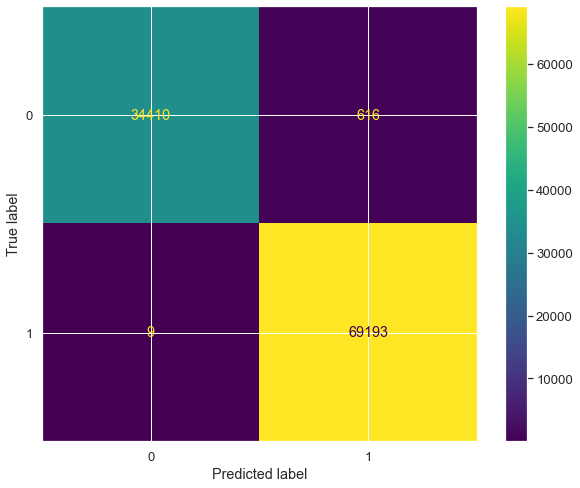



Confusion matrix for the test set
[[ 3955   852]
 [ 4870 16380]]


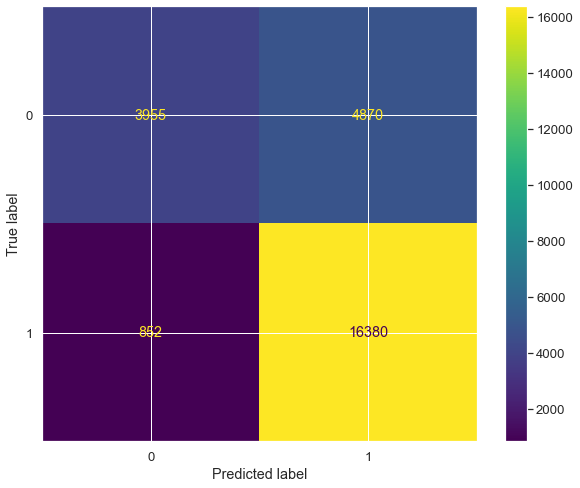

In [259]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                         precision_score(y_TF_train, y_TF_train_pred_rf),
                                         recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})

display(performance_df)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train,y_TF_train_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_train, y_TF_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test,y_TF_test_pred_rf).T)
plot_confusion_matrix(rf1, X_TF_test,y_TF_test, values_format = 'd')
plt.show()

In [271]:
# What's wrong with the confusion matrix??

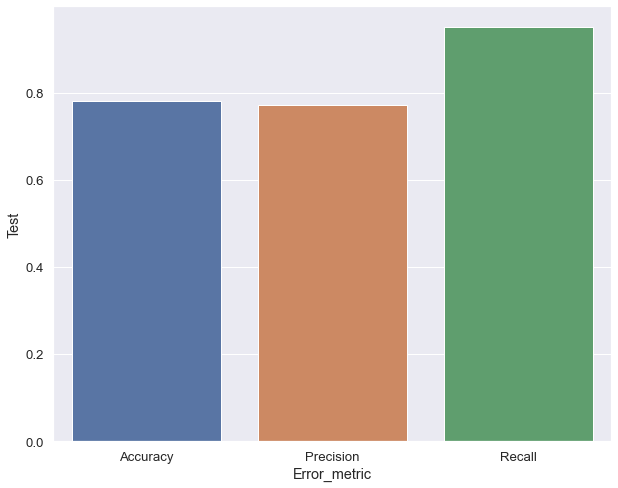

In [260]:
ax = sns.barplot(x="Error_metric", y="Test", data=performance_df)

## Forming LIST 1: POS tagging instead of stopwords

### Applying tags and filtering POS

In [261]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

### Tokenizing

In [262]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [263]:
list_filtered = filter_review(str(corpus_pre_tok))

In [264]:
len(list_filtered)

3110618

### Reducing the list

In [272]:
corpus = [(wordfreq[key],key) for key in list(wordfreq.keys()) if key not in stop_words]
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [266]:
corpus.sort(reverse = True)

corpus_freq = [(word[1],word[0]) for word in corpus[:31]] 
corpus_freq = corpus_freq[1:]
corpus_freq

[('im', 44652),
 ('side', 42947),
 ('taking', 42381),
 ('mg', 40053),
 ('pain', 38340),
 ('years', 37515),
 ('take', 36678),
 ('ive', 36646),
 ('effects', 36298),
 ('first', 35215),
 ('started', 34109),
 ('like', 33936),
 ('months', 33009),
 ('get', 32924),
 ('days', 32834),
 ('time', 31037),
 ('feel', 29010),
 ('would', 26471),
 ('back', 25441),
 ('one', 24313),
 ('weeks', 23491),
 ('pill', 23420),
 ('medication', 23411),
 ('took', 22815),
 ('week', 22548),
 ('also', 22533),
 ('doctor', 22515),
 ('weight', 21075),
 ('got', 20976),
 ('life', 20669)]

In [ ]:
# exact same set as without POS tagging and filtering... no need to re-run models.

# DOWNSAMPLE: to balance higher num of high rating

In [275]:
reviews_cleaned

review  rating
0       it has no side effect i take it in combination...       1
1       my son is halfway through his fourth week of i...       1
2       i used to take another oral contraceptive whic...       0
3       this is my first time using any form of birth ...       1
4       suboxone has completely turned my life around ...       1
...                                                   ...     ...
130280  have been taking it for   years   milligrams n...       1
130281  ive been on clomipramine   years now and basic...       1
130282  i now suffer from excessive tiredness and lack...       1
130283  i have taken tamoxifen for   years side effect...       1
130284  ive been taking lexapro escitaploprgram since ...       1

[130285 rows x 2 columns]

In [276]:
# Splitting df 

category_0 = reviews_cleaned[reviews_cleaned['rating'] == 0]
category_1 = reviews_cleaned[reviews_cleaned['rating'] == 1]
category_1
category_0

review  rating
2       i used to take another oral contraceptive whic...       0
5       nd day on  mg started to work with rock hard e...       0
6       he pulled out but he cummed a bit in me i took...       0
8       i ve had nothing but problems with the keppera...       0
12      i had crohns with a resection   years ago and ...       0
...                                                   ...     ...
130260  started using lisinopril stopping water pill d...       0
130261  i split the tablets into   portions and i slee...       0
130262  after sucessfully taking avinza    x daily i w...       0
130271  i started burning and itching after taking a a...       0
130277  i am   yr old female have taken combination of...       0

[43851 rows x 2 columns]

In [277]:
# Filtering df according to minority group 

category_1 = category_1.sample(len(category_0))
print(category_0.shape)
print(category_1.shape)

(43851, 2)
(43851, 2)


In [278]:
# Putting together the two splits

df_down = pd.concat([category_0, category_1], axis=0)
df_down = df_down.sample(frac=1)
df_down['rating'].value_counts()
df_down 

review  rating
15422   this is my first yi i am   and my sister recom...       0
116676  first medicine i was put on for high blood pre...       1
100775  i was told for years prozac would be great for...       1
115348  i originally started taking metoprolol   mg on...       0
129396  no side effects that i can tell may also be he...       1
...                                                   ...     ...
72645   i suffer from rls symptoms that start in the e...       1
108576  been on paroxetine for   weeks and still no ch...       0
2775    i have been on loestrin   for about   months n...       0
88882   been on patch going on   months i love it noti...       1
3291    i have been on  mg methadone oral liquid for  ...       0

[87702 rows x 2 columns]

### Re-running models with downsample

In [279]:
reviews2 = ['']
corpus2=[]
for review in df_down['review']:
    reviews2.append(review)
    corpus2.append(nltk.sent_tokenize(review))
corpus2

[['this is my first yi i am   and my sister recommend this product i cant sit i cant sleep it is     and im exhausted i have to wake up in   hours for work and i cant sleep through this horrible pain never again'],
 ['first medicine i was put on for high blood pressure and no negative reactions very satisfied many people have to take various medicines before finding a good quot fit quot'],
 ['i was told for years prozac would be great for me when my doctor told me about prozac for my hot flashes i signed on asap i was hoping for a double whamie yes they took care of the hot flashes rather quickly and the happiness side a bit later i am on  mg and would like to get a larger dosage next conversation with the doctor try it'],
 ['i originally started taking metoprolol   mg once a day due to svts they helped calm them down a bit i also have pvcs and pacs especially when my blood pressure is superhigh i am now back on this medication and started at   mg within a few months it was up to   mg 

In [280]:
len(corpus2)

87702

In [281]:
corpus2=[sent for sublist in corpus2 for sent in sublist]
corpus2

['this is my first yi i am   and my sister recommend this product i cant sit i cant sleep it is     and im exhausted i have to wake up in   hours for work and i cant sleep through this horrible pain never again',
 'first medicine i was put on for high blood pressure and no negative reactions very satisfied many people have to take various medicines before finding a good quot fit quot',
 'i was told for years prozac would be great for me when my doctor told me about prozac for my hot flashes i signed on asap i was hoping for a double whamie yes they took care of the hot flashes rather quickly and the happiness side a bit later i am on  mg and would like to get a larger dosage next conversation with the doctor try it',
 'i originally started taking metoprolol   mg once a day due to svts they helped calm them down a bit i also have pvcs and pacs especially when my blood pressure is superhigh i am now back on this medication and started at   mg within a few months it was up to   mg i recen

In [282]:
len(corpus2)

87702

### Cleaning corpus

In [283]:
for i in range(len(corpus2)):
    corpus2[i] = re.sub(r'\d+','', corpus2[i]) # Replace one or more digits by  ' '
    corpus2[i] = re.sub(r"\s*'\s*\w*"," ", corpus2[i])
    corpus2[i] = re.sub(r'\W+',' ',corpus2[i]) # Replace everything non-alpahnumeric by ' '
    corpus2[i] = re.sub(r'\s+',' ', corpus2[i]) # Replace one or more whitespaces by  ' '    
    corpus2[i] = re.sub(r'^\s+|\s+?$','', corpus2[i])
corpus2

['this is my first yi i am and my sister recommend this product i cant sit i cant sleep it is and im exhausted i have to wake up in hours for work and i cant sleep through this horrible pain never again',
 'first medicine i was put on for high blood pressure and no negative reactions very satisfied many people have to take various medicines before finding a good quot fit quot',
 'i was told for years prozac would be great for me when my doctor told me about prozac for my hot flashes i signed on asap i was hoping for a double whamie yes they took care of the hot flashes rather quickly and the happiness side a bit later i am on mg and would like to get a larger dosage next conversation with the doctor try it',
 'i originally started taking metoprolol mg once a day due to svts they helped calm them down a bit i also have pvcs and pacs especially when my blood pressure is superhigh i am now back on this medication and started at mg within a few months it was up to mg i recently went up mg 

In [284]:
corpus2_pre_tok = corpus2.copy()
corpus2_pre_tok

['this is my first yi i am and my sister recommend this product i cant sit i cant sleep it is and im exhausted i have to wake up in hours for work and i cant sleep through this horrible pain never again',
 'first medicine i was put on for high blood pressure and no negative reactions very satisfied many people have to take various medicines before finding a good quot fit quot',
 'i was told for years prozac would be great for me when my doctor told me about prozac for my hot flashes i signed on asap i was hoping for a double whamie yes they took care of the hot flashes rather quickly and the happiness side a bit later i am on mg and would like to get a larger dosage next conversation with the doctor try it',
 'i originally started taking metoprolol mg once a day due to svts they helped calm them down a bit i also have pvcs and pacs especially when my blood pressure is superhigh i am now back on this medication and started at mg within a few months it was up to mg i recently went up mg 

In [285]:
# Tokenizing the corpus

In [286]:
wordfreq2 = {}
for sentence in corpus2:
    words2 = sentence.split()
    #tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in words2:
        if ( word not in wordfreq2.keys() ): ## first time appearnce in the sentence
            wordfreq2[word] = 1 # We initialize the corresponding counter
        else: ## if the world is already existed in the dictionalry 
            wordfreq2[word] += 1 # We increase the corresponding counter

In [287]:
len(list(wordfreq2.keys()))

41297

In [288]:
wordfreq2

{'this': 77726,
 'is': 58772,
 'my': 156905,
 'first': 23559,
 'yi': 590,
 'i': 400924,
 'am': 31398,
 'and': 232152,
 'sister': 178,
 'recommend': 5605,
 'product': 2826,
 'cant': 6379,
 'sit': 672,
 'sleep': 10897,
 'it': 154283,
 'im': 30916,
 'exhausted': 609,
 'have': 89787,
 'to': 176121,
 'wake': 2056,
 'up': 23087,
 'in': 68597,
 'hours': 9133,
 'for': 107773,
 'work': 11835,
 'through': 5074,
 'horrible': 6269,
 'pain': 25698,
 'never': 12921,
 'again': 10103,
 'medicine': 11617,
 'was': 96665,
 'put': 7780,
 'on': 73518,
 'high': 3751,
 'blood': 5505,
 'pressure': 3303,
 'no': 30841,
 'negative': 2131,
 'reactions': 425,
 'very': 21010,
 'satisfied': 295,
 'many': 5097,
 'people': 4249,
 'take': 23350,
 'various': 334,
 'medicines': 1886,
 'before': 14716,
 'finding': 483,
 'a': 152860,
 'good': 10119,
 'quot': 11431,
 'fit': 317,
 'told': 4724,
 'years': 23005,
 'prozac': 1123,
 'would': 17941,
 'be': 21863,
 'great': 9202,
 'me': 62678,
 'when': 19376,
 'doctor': 15325,
 'a

### Reducing the corpus

#### POS tagging

In [289]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

#### Generating LIST 2 [down]

In [290]:
def filter_review(x):
    text = word_tokenize(x)
    # Apply an steemer
    tags = nltk.pos_tag(text)
    words = []
    for tag in tags:
        # Include the type of words that you want to consider.
        # It will be also better 
        if ( tag[1] in ['JJ','NN'] ):
            words.append(tag[0])
    return words[1:-1]

In [291]:
list_filtered2 = filter_review(str(corpus2_pre_tok))

In [292]:
len(list_filtered2)

2090562

In [293]:
list_filtered2

['first',
 'yi',
 'i',
 'sister',
 'recommend',
 'product',
 'i',
 'sit',
 'i',
 'sleep',
 'im',
 'work',
 'i',
 'cant',
 'sleep',
 'horrible',
 'pain',
 'medicine',
 'i',
 'high',
 'blood',
 'pressure',
 'negative',
 'many',
 'various',
 'good',
 'quot',
 'fit',
 'quot',
 'i',
 'great',
 'doctor',
 'prozac',
 'hot',
 'asap',
 'i',
 'double',
 'whamie',
 'yes',
 'care',
 'hot',
 'happiness',
 'side',
 'bit',
 'i',
 'mg',
 'dosage',
 'next',
 'conversation',
 'doctor',
 'i',
 'metoprolol',
 'mg',
 'day',
 'due',
 'bit',
 'i',
 'pacs',
 'blood',
 'pressure',
 'superhigh',
 'i',
 'medication',
 'mg',
 'few',
 'i',
 'mg',
 'cardiologist',
 'mg',
 'i',
 'pill',
 'half',
 'mg',
 'blood',
 'pressure',
 'diet',
 'inc',
 'swimming',
 'walking',
 'exercise',
 'f',
 'lbs',
 'sedentary',
 'life',
 'side',
 'food',
 'directed',
 'nausea',
 'w',
 'o',
 'food',
 "'no",
 'side',
 'i',
 'arthritic',
 'pain',
 'i',
 'mg',
 'oxy',
 'mg',
 'acetaminophen',
 'yrs',
 'i',
 'unable',
 'surgery',
 'microdisc'

In [294]:
# Matching with frequencies

In [295]:
wordfreq3 = {}
for word in list_filtered2:
    if ( word not in wordfreq3.keys() ): ## first time appearnce in the sentence
        wordfreq3[word] = 1 # We initialize the corresponding counter
    else: ## if the world is already existed in the dictionalry 
        wordfreq3[word] += 1 # We increase the corresponding counter

In [296]:
len(list(wordfreq3.keys()))

29018

In [297]:
wordfreq3

{'first': 20348,
 'yi': 540,
 'i': 302356,
 'sister': 178,
 'recommend': 405,
 'product': 2819,
 'sit': 195,
 'sleep': 5431,
 'im': 18045,
 'work': 5947,
 'cant': 2729,
 'horrible': 5999,
 'pain': 24262,
 'medicine': 11497,
 'high': 3713,
 'blood': 5376,
 'pressure': 3298,
 'negative': 2115,
 'many': 5075,
 'various': 332,
 'good': 9971,
 'quot': 8653,
 'fit': 228,
 'great': 8963,
 'doctor': 15129,
 'prozac': 931,
 'hot': 1768,
 'asap': 209,
 'double': 278,
 'whamie': 1,
 'yes': 114,
 'care': 1285,
 'happiness': 116,
 'side': 27499,
 'bit': 3274,
 'mg': 19368,
 'dosage': 2748,
 'next': 5291,
 'conversation': 86,
 'metoprolol': 166,
 'day': 32254,
 'due': 4910,
 'pacs': 8,
 'superhigh': 1,
 'medication': 15621,
 'few': 9725,
 'cardiologist': 196,
 'pill': 16409,
 'half': 3292,
 'diet': 1731,
 'inc': 6,
 'swimming': 12,
 'walking': 167,
 'exercise': 1323,
 'f': 81,
 'lbs': 3923,
 'sedentary': 14,
 'life': 12400,
 'food': 2213,
 'directed': 76,
 'nausea': 6124,
 'w': 409,
 'o': 245,
 "'no

In [298]:
corpus3 = [(wordfreq3[key],key) for key in list(wordfreq3.keys()) if key not in stop_words]
corpus3

[(20348, 'first'),
 (540, 'yi'),
 (178, 'sister'),
 (405, 'recommend'),
 (2819, 'product'),
 (195, 'sit'),
 (5431, 'sleep'),
 (18045, 'im'),
 (5947, 'work'),
 (2729, 'cant'),
 (5999, 'horrible'),
 (24262, 'pain'),
 (11497, 'medicine'),
 (3713, 'high'),
 (5376, 'blood'),
 (3298, 'pressure'),
 (2115, 'negative'),
 (5075, 'many'),
 (332, 'various'),
 (9971, 'good'),
 (8653, 'quot'),
 (228, 'fit'),
 (8963, 'great'),
 (15129, 'doctor'),
 (931, 'prozac'),
 (1768, 'hot'),
 (209, 'asap'),
 (278, 'double'),
 (1, 'whamie'),
 (114, 'yes'),
 (1285, 'care'),
 (116, 'happiness'),
 (27499, 'side'),
 (3274, 'bit'),
 (19368, 'mg'),
 (2748, 'dosage'),
 (5291, 'next'),
 (86, 'conversation'),
 (166, 'metoprolol'),
 (32254, 'day'),
 (4910, 'due'),
 (8, 'pacs'),
 (1, 'superhigh'),
 (15621, 'medication'),
 (196, 'cardiologist'),
 (16409, 'pill'),
 (3292, 'half'),
 (1731, 'diet'),
 (6, 'inc'),
 (12, 'swimming'),
 (167, 'walking'),
 (1323, 'exercise'),
 (81, 'f'),
 (3923, 'lbs'),
 (14, 'sedentary'),
 (12400, '

In [299]:
corpus3.sort(reverse = True)
corpus_freq3 = [(word[1],word[0]) for word in corpus3[:31]] 
corpus_freq3 = corpus_freq3[1:]
corpus_freq3

[('side', 27499),
 ('pain', 24262),
 ('time', 20892),
 ('first', 20348),
 ('mg', 19368),
 ('im', 18045),
 ('ive', 17096),
 ('pill', 16409),
 ('medication', 15621),
 ('week', 15332),
 ('doctor', 15129),
 ('month', 13893),
 ('period', 13715),
 ('bad', 13660),
 ('anxiety', 13055),
 ('weight', 12688),
 ('life', 12400),
 ('medicine', 11497),
 ('night', 11146),
 ('good', 9971),
 ('drug', 9942),
 ('year', 9909),
 ('control', 9302),
 ('great', 8963),
 ('quot', 8653),
 ('depression', 8651),
 ('last', 8585),
 ('birth', 8396),
 ('dose', 8026),
 ('much', 8005)]

In [300]:
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
lem = WordNetLemmatizer()

corpus_freq3 = [(lem.lemmatize(word[0]),word[1]) for word in corpus_freq3]
corpus_freq3

[nltk_data] Downloading package omw-1.4 to /Users/odelia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[('side', 27499),
 ('pain', 24262),
 ('time', 20892),
 ('first', 20348),
 ('mg', 19368),
 ('im', 18045),
 ('ive', 17096),
 ('pill', 16409),
 ('medication', 15621),
 ('week', 15332),
 ('doctor', 15129),
 ('month', 13893),
 ('period', 13715),
 ('bad', 13660),
 ('anxiety', 13055),
 ('weight', 12688),
 ('life', 12400),
 ('medicine', 11497),
 ('night', 11146),
 ('good', 9971),
 ('drug', 9942),
 ('year', 9909),
 ('control', 9302),
 ('great', 8963),
 ('quot', 8653),
 ('depression', 8651),
 ('last', 8585),
 ('birth', 8396),
 ('dose', 8026),
 ('much', 8005)]

In [301]:
cols2 = {word[0]: [] for word in corpus_freq3}
reviews2 = pd.DataFrame(cols2)

reviews2.columns

Index(['side', 'pain', 'time', 'first', 'mg', 'im', 'ive', 'pill',
       'medication', 'week', 'doctor', 'month', 'period', 'bad', 'anxiety',
       'weight', 'life', 'medicine', 'night', 'good', 'drug', 'year',
       'control', 'great', 'quot', 'depression', 'last', 'birth', 'dose',
       'much'],
      dtype='object')

In [302]:
cols2

{'side': [],
 'pain': [],
 'time': [],
 'first': [],
 'mg': [],
 'im': [],
 'ive': [],
 'pill': [],
 'medication': [],
 'week': [],
 'doctor': [],
 'month': [],
 'period': [],
 'bad': [],
 'anxiety': [],
 'weight': [],
 'life': [],
 'medicine': [],
 'night': [],
 'good': [],
 'drug': [],
 'year': [],
 'control': [],
 'great': [],
 'quot': [],
 'depression': [],
 'last': [],
 'birth': [],
 'dose': [],
 'much': []}

In [303]:
def review_inpector(sentence, stop_words, words):

    import re

    # Decompose the review in words -> tokens
    tokens = nltk.word_tokenize(sentence)
    # Clean up the token
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tokens[i] = re.sub(r'\W',' ',tokens[i]) # Replace everything non-alpahnumeric by ' '
        tokens[i] = re.sub(r'\s+','',tokens[i]) # Replace one or more whitespaces by  ' '
        tokens[i] = re.sub(r'\d+','',tokens[i]) # Replace one or more digits by  ' '
        tokens[i] = lem.lemmatize(tokens[i])
        
    # Dropping tokens which are "stopwords" or empty
    tokens = [ token for token in tokens if (token not in stop_words and token != '')]

    # Initializing an empty dictionary of word frequencies for the corresponding review
    col_freq = {col:0 for col in words}
    
    # Filling the dictionary with word frequencies in the review
    for token in tokens:
        if token in words:
            col_freq[token] += 1

    return col_freq

In [304]:
my_list2 = list(map(review_inpector, df_down['review'], 
                    [stop_words]*df.shape[0], [list(cols2.keys())]*df.shape[0] ) )

my_list2[:2]

[{'side': 0,
  'pain': 1,
  'time': 0,
  'first': 1,
  'mg': 0,
  'im': 1,
  'ive': 0,
  'pill': 0,
  'medication': 0,
  'week': 0,
  'doctor': 0,
  'month': 0,
  'period': 0,
  'bad': 0,
  'anxiety': 0,
  'weight': 0,
  'life': 0,
  'medicine': 0,
  'night': 0,
  'good': 0,
  'drug': 0,
  'year': 0,
  'control': 0,
  'great': 0,
  'quot': 0,
  'depression': 0,
  'last': 0,
  'birth': 0,
  'dose': 0,
  'much': 0},
 {'side': 0,
  'pain': 0,
  'time': 0,
  'first': 1,
  'mg': 0,
  'im': 0,
  'ive': 0,
  'pill': 0,
  'medication': 0,
  'week': 0,
  'doctor': 0,
  'month': 0,
  'period': 0,
  'bad': 0,
  'anxiety': 0,
  'weight': 0,
  'life': 0,
  'medicine': 2,
  'night': 0,
  'good': 1,
  'drug': 0,
  'year': 0,
  'control': 0,
  'great': 0,
  'quot': 2,
  'depression': 0,
  'last': 0,
  'birth': 0,
  'dose': 0,
  'much': 0}]

In [305]:
reviews2 = pd.DataFrame(my_list2)

In [306]:
reviews2

side  pain  time  first  mg  im  ive  pill  medication  week  ...  \
0         0     1     0      1   0   1    0     0           0     0  ...   
1         0     0     0      1   0   0    0     0           0     0  ...   
2         1     0     0      0   1   0    0     0           0     0  ...   
3         1     0     0      0   8   0    0     1           1     0  ...   
4         1     1     0      0   0   0    0     0           0     0  ...   
...     ...   ...   ...    ...  ..  ..  ...   ...         ...   ...  ...   
87697     0     0     0      0   0   0    0     0           0     0  ...   
87698     0     0     0      0   0   0    0     0           0     1  ...   
87699     0     0     0      1   0   0    0     0           0     0  ...   
87700     0     0     0      0   0   0    0     0           0     0  ...   
87701     0     2     0      0   4   0    0     0           1     0  ...   

       drug  year  control  great  quot  depression  last  birth  dose  much  
0         0     0        0      0     0           0     0      0     0     0  
1         0     0        0      0     2           0     0      0     0     0  
2         0     1        0      1     0           0     0      0     0     0  
3         0     1        0      0     0           0     0      0     0     0  
4         0     0        0      0     0           0     0      0     0     0  
...     ...   ...      ...    ...   ...         ...   ...    ...   ...   ...  
87697     0     0        0      0     0           0     0      0     0     0  
87698     0     0        0      0     0           0     0      0     0     0  
87699     0     1        0      0     0           0     1      0     0     0  
87700     0     0        0      0     0           0     0      0     0     0  
87701     1     3        0      0     0           0     0      0     1     0  

[87702 rows x 30 columns]

In [307]:
reviews2['rating'] = df_down['rating'].reset_index(drop=True)
reviews2

side  pain  time  first  mg  im  ive  pill  medication  week  ...  \
0         0     1     0      1   0   1    0     0           0     0  ...   
1         0     0     0      1   0   0    0     0           0     0  ...   
2         1     0     0      0   1   0    0     0           0     0  ...   
3         1     0     0      0   8   0    0     1           1     0  ...   
4         1     1     0      0   0   0    0     0           0     0  ...   
...     ...   ...   ...    ...  ..  ..  ...   ...         ...   ...  ...   
87697     0     0     0      0   0   0    0     0           0     0  ...   
87698     0     0     0      0   0   0    0     0           0     1  ...   
87699     0     0     0      1   0   0    0     0           0     0  ...   
87700     0     0     0      0   0   0    0     0           0     0  ...   
87701     0     2     0      0   4   0    0     0           1     0  ...   

       year  control  great  quot  depression  last  birth  dose  much  rating  
0         0        0      0     0           0     0      0     0     0       0  
1         0        0      0     2           0     0      0     0     0       1  
2         1        0      1     0           0     0      0     0     0       1  
3         1        0      0     0           0     0      0     0     0       0  
4         0        0      0     0           0     0      0     0     0       1  
...     ...      ...    ...   ...         ...   ...    ...   ...   ...     ...  
87697     0        0      0     0           0     0      0     0     0       1  
87698     0        0      0     0           0     0      0     0     0       0  
87699     1        0      0     0           0     1      0     0     0       0  
87700     0        0      0     0           0     0      0     0     0       1  
87701     3        0      0     0           0     0      0     1     0       0  

[87702 rows x 31 columns]

## Modeling (DOWNSAMPLE)

### Cross-validation?

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

## >>> Running the RanFor Model with BOW

In [308]:
X2 = reviews2.drop(columns='rating')
y2 = reviews2['rating']
X2

side  pain  time  first  mg  im  ive  pill  medication  week  ...  \
0         0     1     0      1   0   1    0     0           0     0  ...   
1         0     0     0      1   0   0    0     0           0     0  ...   
2         1     0     0      0   1   0    0     0           0     0  ...   
3         1     0     0      0   8   0    0     1           1     0  ...   
4         1     1     0      0   0   0    0     0           0     0  ...   
...     ...   ...   ...    ...  ..  ..  ...   ...         ...   ...  ...   
87697     0     0     0      0   0   0    0     0           0     0  ...   
87698     0     0     0      0   0   0    0     0           0     1  ...   
87699     0     0     0      1   0   0    0     0           0     0  ...   
87700     0     0     0      0   0   0    0     0           0     0  ...   
87701     0     2     0      0   4   0    0     0           1     0  ...   

       drug  year  control  great  quot  depression  last  birth  dose  much  
0         0     0        0      0     0           0     0      0     0     0  
1         0     0        0      0     2           0     0      0     0     0  
2         0     1        0      1     0           0     0      0     0     0  
3         0     1        0      0     0           0     0      0     0     0  
4         0     0        0      0     0           0     0      0     0     0  
...     ...   ...      ...    ...   ...         ...   ...    ...   ...   ...  
87697     0     0        0      0     0           0     0      0     0     0  
87698     0     0        0      0     0           0     0      0     0     0  
87699     0     1        0      0     0           0     1      0     0     0  
87700     0     0        0      0     0           0     0      0     0     0  
87701     1     3        0      0     0           0     0      0     1     0  

[87702 rows x 30 columns]

In [309]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=42)

X_train2 = pd.DataFrame(X_train2, columns=X2.columns)
X_test2  = pd.DataFrame(X_test2, columns=X2.columns)

y_train2 = pd.DataFrame(y_train2, columns =['rating'])
y_test2  = pd.DataFrame(y_test2, columns =['rating'])

In [314]:
X_train2
y_train2
X_test2

side  pain  time  first  mg  im  ive  pill  medication  week  ...  \
39307     0     0     1      0   0   0    1     4           0     0  ...   
78273     0     1     0      0   0   2    0     1           0     0  ...   
78355     0     0     0      0   1   2    0     0           0     2  ...   
56237     2     0     0      0   2   0    0     0           1     0  ...   
49016     0     0     0      0   0   1    0     0           2     0  ...   
...     ...   ...   ...    ...  ..  ..  ...   ...         ...   ...  ...   
64113     0     0     0      0   0   0    0     0           0     0  ...   
61685     1     0     0      0   3   1    0     0           0     0  ...   
642       0     0     0      0   2   0    1     0           0     1  ...   
83744     0     1     0      0   0   0    0     0           0     0  ...   
1427      0     0     0      0   0   0    0     0           0     1  ...   

       drug  year  control  great  quot  depression  last  birth  dose  much  
39307     0     1        1      0     0           0     1      1     0     0  
78273     0     0        0      0     0           0     0      0     0     1  
78355     0     0        0      0     0           0     0      0     0     0  
56237     0     1        0      0     0           1     0      0     0     0  
49016     0     2        0      0     0           0     0      0     0     0  
...     ...   ...      ...    ...   ...         ...   ...    ...   ...   ...  
64113     0     0        0      0     0           0     0      0     0     0  
61685     0     0        0      0     0           2     0      0     0     0  
642       0     0        0      0     0           0     0      0     0     0  
83744     0     0        0      0     0           0     0      0     0     1  
1427      0     0        0      1     0           0     0      0     0     0  

[17541 rows x 30 columns]

In [311]:
y_test2.value_counts()

rating
0         8780
1         8761
dtype: int64

In [312]:
rf2 = RandomForestClassifier()

rf2.fit(X_train2, y_train2['rating'])

RandomForestClassifier()

### Making predictions with RF

In [315]:
y_train_pred_rf2 = rf2.predict(X_train2)
y_test_pred_rf2  = rf2.predict(X_test2)

In [316]:
def model_performance_class(y_train, y_pred_train, y_test, y_pred_test):

    from sklearn.metrics import cohen_kappa_score, classification_report 


    print("Results obtained for the TRAIN SET")
    print("==================================")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_train, y_pred_train)))
    print(classification_report(y_train, y_pred_train))
    print("==================================")
    print("Results obtained for the TEST SET")
    print("The Cohen's Kappa is: {:.2f}".format(cohen_kappa_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test))

### Model performance

In [317]:
model_performance_class(y_train2, y_train_pred_rf2, y_test2, y_test_pred_rf2)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.77
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     35071
           1       0.92      0.84      0.88     35090

    accuracy                           0.88     70161
   macro avg       0.89      0.88      0.88     70161
weighted avg       0.89      0.88      0.88     70161

Results obtained for the TEST SET
The Cohen's Kappa is: 0.21
              precision    recall  f1-score   support

           0       0.60      0.65      0.62      8780
           1       0.61      0.56      0.59      8761

    accuracy                           0.60     17541
   macro avg       0.60      0.60      0.60     17541
weighted avg       0.60      0.60      0.60     17541



#### Tuning the hyper paramters with gridsearch

In [318]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [319]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [321]:
grid_search.fit(X_train2,y_train2)

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/envs/OA_DA_env/lib/python3.9/site-packages/sklearn/model_selection/_va

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100]},
             return_train_score=True)

In [322]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [350]:
clf = RandomForestClassifier(bootstrap=False, max_depth=10,max_features="sqrt",n_estimators=100, min_samples_leaf = 2, random_state=42)
clf.fit(X_train2, y_train2)
print(clf.score(X_train2, y_train2))
print(clf.score(X_test2, y_test2))

0.6446743917561039
0.62066016760732


In [352]:
pd.DataFrame(grid_search.cv_results_)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [354]:
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

0.6042672551706566


## TF_IDF DOWNSAMPLE

### >>> With uni + bigrams

In [323]:
df_down

review  rating
15422   this is my first yi i am   and my sister recom...       0
116676  first medicine i was put on for high blood pre...       1
100775  i was told for years prozac would be great for...       1
115348  i originally started taking metoprolol   mg on...       0
129396  no side effects that i can tell may also be he...       1
...                                                   ...     ...
72645   i suffer from rls symptoms that start in the e...       1
108576  been on paroxetine for   weeks and still no ch...       0
2775    i have been on loestrin   for about   months n...       0
88882   been on patch going on   months i love it noti...       1
3291    i have been on  mg methadone oral liquid for  ...       0

[87702 rows x 2 columns]

In [324]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (1,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [325]:
X_TF2 = tidf.fit_transform(df_down['review'])
y_TF2 = df_down['rating']

In [326]:
y_TF2

15422     0
116676    1
100775    1
115348    0
129396    1
         ..
72645     1
108576    0
2775      0
88882     1
3291      0
Name: rating, Length: 87702, dtype: int64

In [327]:
tidf.get_feature_names()

['aa',
 'abdomen',
 'abdominal',
 'abdominal cramping',
 'abdominal cramps',
 'abdominal pain',
 'abdominal pains',
 'abilify',
 'abilify mg',
 'abilities',
 'ability',
 'ablation',
 'able',
 'able breathe',
 'able concentrate',
 'able continue',
 'able control',
 'able cope',
 'able drive',
 'able eat',
 'able enjoy',
 'able fall',
 'able feel',
 'able find',
 'able focus',
 'able function',
 'able get',
 'able go',
 'able handle',
 'able hold',
 'able keep',
 'able leave',
 'able live',
 'able lose',
 'able make',
 'able move',
 'able quit',
 'able sex',
 'able sleep',
 'able stay',
 'able stop',
 'able take',
 'able think',
 'able tolerate',
 'able use',
 'able walk',
 'able work',
 'abnormal',
 'abnormal bleeding',
 'abortion',
 'abreva',
 'abruptly',
 'abscess',
 'absence',
 'absolute',
 'absolute worst',
 'absolutely',
 'absolutely amazing',
 'absolutely awful',
 'absolutely hate',
 'absolutely horrible',
 'absolutely love',
 'absolutely loved',
 'absolutely miserable',
 'absolut

In [328]:
len(tidf.get_feature_names())

20000

In [329]:
X_TF2[:2,:5]

<2x5 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

#### Train test split

In [330]:
X_TF_train2, X_TF_test2, y_TF_train2, y_TF_test2 = train_test_split(X_TF2, y_TF2, test_size=0.20, random_state=42)

In [331]:
type(X_TF_train2)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [372]:
rf3 = RandomForestClassifier(max_depth=50, n_estimators=50)

y_TF_train2 = y_TF_train2.astype('int')
y_TF_test2  = y_TF_test2.astype('int')

rf3.fit(X_TF_train2, y_TF_train2)

y_TF_train_pred_rf2 = rf3.predict(X_TF_train2)
y_TF_test_pred_rf2  = rf3.predict(X_TF_test2)

#### Model performance

In [373]:
model_performance_class(y_TF_train2, y_TF_train_pred_rf2, y_TF_test2, y_TF_test_pred_rf2)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.88
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     35071
           1       0.95      0.93      0.94     35090

    accuracy                           0.94     70161
   macro avg       0.94      0.94      0.94     70161
weighted avg       0.94      0.94      0.94     70161

Results obtained for the TEST SET
The Cohen's Kappa is: 0.54
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      8780
           1       0.78      0.76      0.77      8761

    accuracy                           0.77     17541
   macro avg       0.77      0.77      0.77     17541
weighted avg       0.77      0.77      0.77     17541



In [334]:
# best results obtained with uni- AND bi-grams, max_depth 200

Error_metric     Train      Test
0     Accuracy  0.997848  0.777607
1    Precision  0.999086  0.783879
2       Recall  0.996609  0.765894

Confusion matrix for the train set
[[35039   119]
 [   32 34971]]


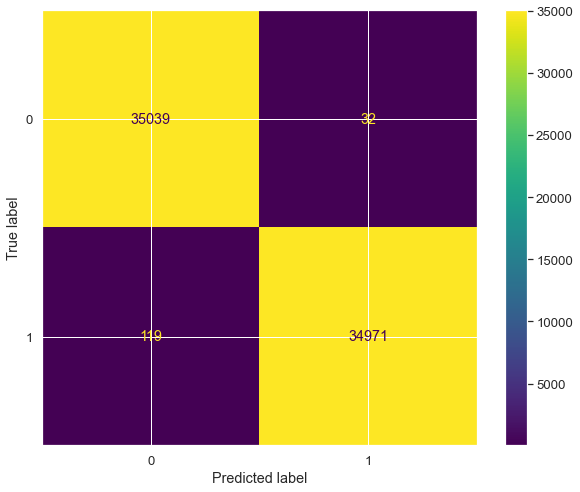



Confusion matrix for the test set
[[6930 2051]
 [1850 6710]]


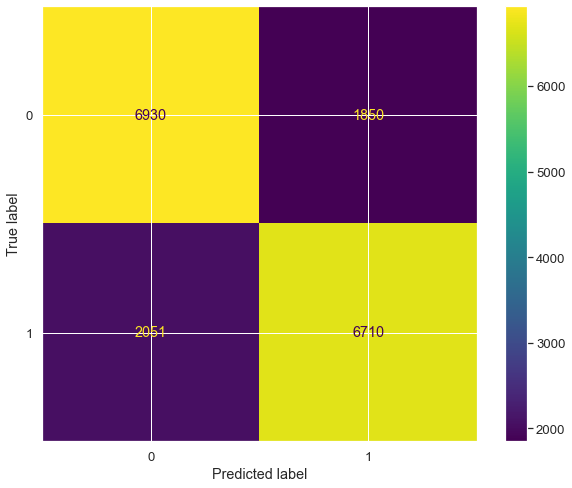

In [335]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

performance_df_best = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                                         precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})

display(performance_df_best)

print("Confusion matrix for the train set")
print(confusion_matrix(y_TF_train2,y_TF_train_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_train2, y_TF_train2, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_TF_test2,y_TF_test_pred_rf2).T)
plot_confusion_matrix(rf3, X_TF_test2,y_TF_test2, values_format = 'd')
plt.show()

### >>> With bigrams only

In [336]:
tidf = TfidfVectorizer(max_features = 20000, ngram_range = (2,2), analyzer = 'word',
                       stop_words = stop_words, min_df=2 )

In [337]:
X_TF_down_bi = tidf.fit_transform(df_down['review'])
y_TF_down_bi = df_down['rating']

#### Train test split

In [338]:
X_TF_down_bi_train, X_TF_down_bi_test, y_TF_down_bi_train, y_TF_down_bi_test = train_test_split(X_TF_down_bi, y_TF_down_bi, test_size=0.20, random_state=42)

In [339]:
type(X_TF_down_bi_train)

scipy.sparse.csr.csr_matrix

#### Generating the model

In [340]:
rf4 = RandomForestClassifier(max_depth=200, n_estimators=50)

y_TF_down_bi_train = y_TF_down_bi_train.astype('int')
y_TF_down_bi_test  = y_TF_down_bi_test.astype('int')

rf4.fit(X_TF_down_bi_train, y_TF_down_bi_train)

y_TF_down_bi_train_pred_rf = rf4.predict(X_TF_down_bi_train)
y_TF_down_bi_test_pred_rf  = rf4.predict(X_TF_down_bi_test)

#### Model performance

In [341]:
model_performance_class(y_TF_down_bi_train, y_TF_down_bi_train_pred_rf, y_TF_down_bi_test, 
                        y_TF_down_bi_test_pred_rf)

Results obtained for the TRAIN SET
The Cohen's Kappa is: 0.81
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     35071
           1       0.97      0.84      0.90     35090

    accuracy                           0.91     70161
   macro avg       0.91      0.91      0.91     70161
weighted avg       0.91      0.91      0.91     70161

Results obtained for the TEST SET
The Cohen's Kappa is: 0.43
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      8780
           1       0.75      0.65      0.69      8761

    accuracy                           0.71     17541
   macro avg       0.72      0.71      0.71     17541
weighted avg       0.72      0.71      0.71     17541



#### Tuning the hyper paramters with gridsearch

In [355]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [150, 200],
    'bootstrap': [True, False],
    'min_samples_leaf' : [1, 2],
    'max_features': ['sqrt', 'log2']
    #'max_samples' : ['None', 0.5]
    }
clf = RandomForestClassifier(random_state=42)

In [356]:
grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1,)

In [357]:
grid_search.fit(X_TF_train2,y_TF_train2)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [150, 200],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [50, 100]},
             return_train_score=True)

In [358]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 200,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'n_estimators': 100}

In [359]:
#pd.DataFrame(grid_search.cv_results_)

In [360]:
cross_val_scores = cross_val_score(clf, X_train2, y_train2, cv=10)
print(np.mean(cross_val_scores))

0.6042672551706566


In [361]:
metrics.RocCurveDisplay

sklearn.metrics._plot.roc_curve.RocCurveDisplay

In [362]:
metrics.RocCurveDisplay.from_estimator

<bound method RocCurveDisplay.from_estimator of <class 'sklearn.metrics._plot.roc_curve.RocCurveDisplay'>>

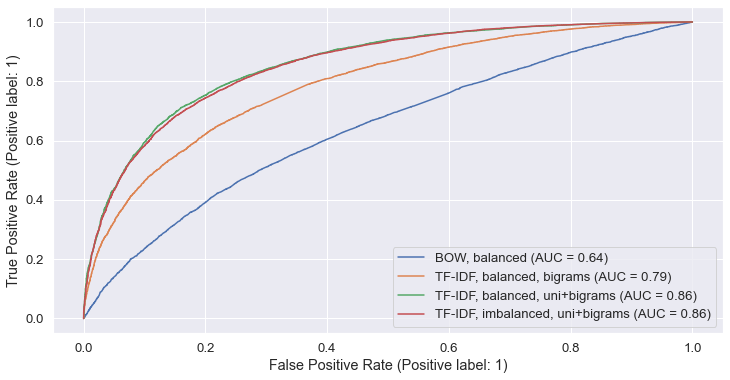

In [363]:
# 1 - BOW, down
disp = plot_roc_curve(rf2, X_test2, y_test2, name="BOW, balanced")
plt.gcf().set_size_inches(12,6)
#2 - TF-IDF down bi grams
plot_roc_curve(rf4, X_TF_down_bi_test, y_TF_down_bi_test, name="TF-IDF, balanced, bigrams", ax=disp.ax_);

#3 - TF-IDF down uni/bi grams
plot_roc_curve(rf3, X_TF_test2, y_TF_test2, name="TF-IDF, balanced, uni+bigrams", ax=disp.ax_);

#4 - TF-IDF full uni/bi grams
plot_roc_curve(rf1, X_TF_test, y_TF_test, name="TF-IDF, imbalanced, uni+bigrams", ax=disp.ax_);

In [364]:
# Plot recall (chose green option as recall for cat 1 is better)

In [365]:
performance_df1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train, y_TF_train_pred_rf),
                                #         precision_score(y_TF_train, y_TF_train_pred_rf),
                                 #        recall_score(y_TF_train, y_TF_train_pred_rf)],
                               'Test': [accuracy_score(y_TF_test, y_TF_test_pred_rf),
                                        precision_score(y_TF_test, y_TF_test_pred_rf),
                                        recall_score(y_TF_test, y_TF_test_pred_rf)]})
performance_df_best1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               #'Train': [accuracy_score(y_TF_train2, y_TF_train_pred_rf2),
                               #          precision_score(y_TF_train2, y_TF_train_pred_rf2),
                                #         recall_score(y_TF_train2, y_TF_train_pred_rf2)],
                               'Test': [accuracy_score(y_TF_test2, y_TF_test_pred_rf2),
                                        precision_score(y_TF_test2, y_TF_test_pred_rf2),
                                        recall_score(y_TF_test2, y_TF_test_pred_rf2)]})


In [366]:
performance_df1

Error_metric      Test
0     Accuracy  0.780404
1    Precision  0.770824
2       Recall  0.950557